### **THE PERFECT MOVIE RECIPE**

Hien Lê, Zafer Kocaoglu, Francesco Maizza, Anita Mezzetti, Nataliia Surianinova

Project structure:
- [DATA WRANGLING](#data_wrangling)

    1. [Features analysis](#column_analysis)
        - [Color](#color)
        - [Year](#Year)
        - [Aspect Ratio](#ar)
        - [Country](#country)
    2. [Drop Duplicates and Key Values](#drop_key)
    3. [Fill NaN values with other datasets](#fill_na)
        - [Wikipedia](#wikipedia)
        - [TMDb](#tmdb)
    4. [Filling or Removing Nan Values](#fill_remove)


- [FEATURE ENGINEERING](#feature_engineering)

    1. [Genres: One Hot Encoding](#genres)
    2. [Rating](#rating)
        - [Director](#director)
        - [Actors: actor 1, actor 2, actor 3](#actors)
        - [Rating Recent Movies](#rat_new)
    3. [Filling Missed Budget Values](#missed_budget)
    4. [Gross Budget Ratio](#ratio)
    

- [EDA (all movies)](#eda)

    1. [Univariate Analysis](#uni)

        - [Some high-level observations](#high_level)
        - [SP500 and Fed](#fed)
        - [Content rating (?)](#content_rating)
        - [(?) prominent director](#prominent_director)

    2. [Bivariate Analysis](#biv)

        - [Relationship between profitability and IMDB score](#prof_imdb)
        - [Average Gross Budget Ratio For Each Genre](#ratio_genre)

    3. [Multivariate Analysis](#multi)

        - [Influence of Social Media?](#social)

    3. [Keywords Analysis](#keys)

        - [Relation between keywords, Budget, Gross and profitability](#rel_keys)
        - [PCA](#pca)
    
    

- [EDA (USA)](#edaam)

- Classification
- Regression


In [1]:
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import collections

# sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate


from collections import OrderedDict, Counter
from matplotlib import pyplot
from random import randint

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
# import data
movie_data = pd.read_csv(r'data/movie_metadata.csv')

In [3]:
print("The features of the movie dataset are:")
print(movie_data.dtypes)

The features of the movie dataset are:
color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64

# Data Wrangling  <a name="data_wrangling"></a>


## 1) Features analysis: <a name="column_analysis"></a>

We check what columns are actually useful. In particular we analyse four of them.

### Color <a name="color"></a>

We check that the color column is binary: a film is *'black and white'* or is *'color'*. 

We drop the color column, because we want to help a modern film company and it is gonna make color films quite surely. Nowadays, the decision to produce a *'black and white'* movie is an usual choice, driven by artistic needs. 

In the next section (year) we will keep only movies produced after the 1980 (we will explain why). We can ignore the color column because mosto of recent movies are 'Color'.

Firstly we verify that *'black and white'* or is *'color'* are the only values of the column:

In [4]:
colors = movie_data.color.unique() # values in the column color
color_values = [x for x in colors if str(x) != 'nan'] # drop nan
#color_values[1] = color_values[1].strip() # delete spaces before 'black'

print(f"The color column has only {len(color_values)} different values: '{color_values[0]}' and '{color_values[1]}'.")

The color column has only 2 different values: 'Color' and ' Black and White'.


In [5]:
# dataframe years and colors:
year_color = movie_data[['color', 'title_year']] # we only need color and year
year_color = year_color[~year_color.color.isnull()] # deletete color NaN values 
year_color = year_color[~year_color.title_year.isnull()]  # deletete title NaN values 
year_color = year_color.sort_values('title_year') # sort by year

years = year_color.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years): 
    year = int(years[i]) # year
    year_movies = year_color.loc[year_color['title_year'] == years[i]].color.values # all colors of film of that year
    
    # number black and white and color movies for each year
    num_c = (year_movies == color_values[0]).sum()
    num_bw = (year_movies == color_values[1]).sum()
    
    # dataframe: for each row year, num colors, num blackwhite
    d = {'year':year , 'num_color':num_c , 'num_black_white':num_bw }
    
    if i==0 :
        year_number_colors = pd.DataFrame( data=d , index=[year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data=d , index=[year])
        year_number_colors = year_number_colors.append(d2, ignore_index=True)
        
print("For each year, we check how many films are colored and how many black and white:")
year_number_colors = year_number_colors.set_index('year')
year_number_colors.head()

For each year, we check how many films are colored and how many black and white:


,num_color,num_black_white
year,,
1916,0,1
1920,0,1
1925,0,1
1927,0,1
1929,0,2


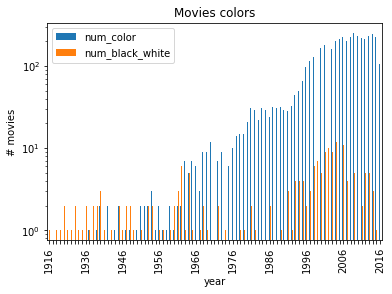

In [6]:
year_number_colors['year']=year_number_colors.index
f=year_number_colors.plot(x="year", y=["num_color", "num_black_white"], kind="bar")
plt.yscale('log', nonposy='clip')
plt.ylabel('# movies')
plt.title("Movies colors")
for ind, label in enumerate(f.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
#f.set_yscale("log")

We can see that most of movies in recent years are *'color'*, so this column is not a relevant feature. We can drop it

In [7]:
movie_data = movie_data.drop('color', axis=1) # drop color column

### Year <a name="year"></a>

Custumers' tastes change really fastly. We have already decided to drop black and white films, because they are not relevant for the analysis. In the same way, we can ignore films which were produced before 1980. As it can be seen in this histogram, this choice does not drop the majority of the movies, which were produced after 1980.

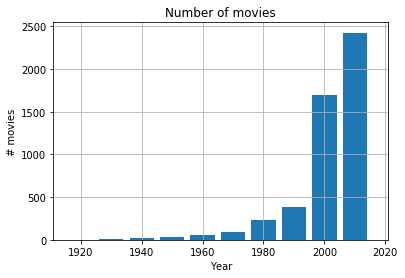

In [8]:
movie_data.title_year.hist( histtype='bar', width = 8)
plt.title("Number of movies")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

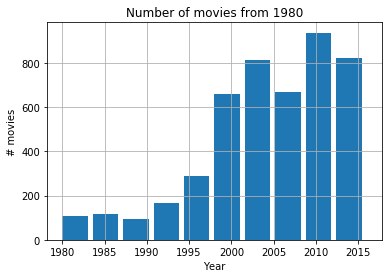

In [9]:
movie_data = movie_data[movie_data.title_year>=1980] # drop film before 1980
movie_data.title_year.hist(width = 3)
plt.title("Number of movies from 1980")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

### Aspect Ratio <a name="ar"></a>

We want to anlyse if the aspect ratio is an intresting feature. Nowadays, there are some rules which says the ratio that film-makers must use (deeper reserch in the report). For example wikipedia says (https://en.wikipedia.org/wiki/Aspect_ratio_(image)) :

The most common aspect ratios used today in the presentation of films in cinemas are 1.85:1 and 2.39:1. Two common videographic aspect ratios are 4:3 (1.3:1), the universal video format of the 20th century, and 16:9 (1.7:1), universal for high-definition television and European digital television. Other cinema and video aspect ratios exist, but are used infrequently.

We investigate for each year what aspect ratios were used. 

In [10]:
ar = movie_data.aspect_ratio.unique() 
ar = [x for x in ar if str(x) != 'nan'] # drop nan
ar = sorted(ar) # sort 

print("The aspect ratios which were used were:")
print(*ar, sep = "\n")

The aspect ratios which were used were:
1.18
1.33
1.37
1.44
1.5
1.66
1.75
1.77
1.78
1.85
1.89
2.0
2.2
2.24
2.35
2.39
2.4
2.55
2.76
16.0


In [11]:
# dataframe years and aspect ratio:
year_ar = movie_data[['title_year', 'aspect_ratio']] # we only need color and year
year_ar = year_ar[~year_ar.aspect_ratio.isnull()] # deletete color NaN values 
year_ar = year_ar[~year_ar.title_year.isnull()]  # deletete title NaN values 
year_ar = year_ar.sort_values('title_year') # sort by year

years = year_ar.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years):  
    year = int(years[i]) # year
    year_movies = year_ar.loc[year_ar['title_year'] == years[i]].aspect_ratio.values # all colors of film of that year
    
    # number of each of the aspect ratios
    num = [] 
    for j in range(len(ar)): # for each aspect ratio
        sum_ar = (year_movies == ar[j]).sum()
        num.append(sum_ar) 
    
    # dataframe: for each row year, num of each aspect ratio
    d = dict(zip(ar, num)) # dictionary to create the dataframe
    
    d['year'] = year
    
    if i==0 :
        year_number_ar = pd.DataFrame( data = d , index = [year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data = d , index = [year])
        year_number_ar = year_number_ar.append(d2, ignore_index=True)
        
print("For each year, we check the number of movies for each ratio:")
year_number_ar = year_number_ar.set_index('year')
year_number_ar.head()

For each year, we check the number of movies for each ratio:


,1.18,1.33,1.37,1.44,1.50,1.66,1.75,1.77,1.78,1.85,1.89,2.00,2.20,2.24,2.35,2.39,2.40,2.55,2.76,16.00
year,,,,,,,,,,,,,,,,,,,,
1980,0,0,1,0,0,0,0,0,0,11,0,0,0,0,12,0,0,0,0,0
1981,0,0,2,0,0,0,0,0,1,15,0,0,0,0,15,0,0,0,0,0
1982,0,0,0,0,0,0,0,0,0,12,0,0,0,0,16,0,0,0,0,0
1983,0,0,0,0,0,0,0,0,0,12,0,0,0,0,8,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,21,0,0,1,0,9,0,0,0,0,0


From this Data Frame we can see that 1.85 and 2.35 have way more movies than all the others ratios. We can plot these two and the sum of all the other and see that the other are irrelevant.

In [12]:
#we sum all the other columns: 

year_number_ar['year'] = year_number_ar.index
year_number_ar['sum'] =  year_number_ar[year_number_ar.columns[0]]
lista = [1,2,3,4,5,6,7,8,10,11,12,13,15,16,17,18,19]

for i in range(len(lista)):
    index = lista[i]
    year_number_ar['sum'] = year_number_ar['sum'] + year_number_ar[year_number_ar.columns[index]]
    

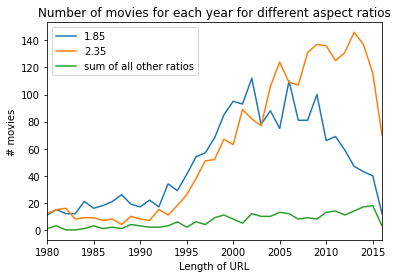

In [13]:
# plot:
# identification of the columns
ar_185 = year_number_ar.columns[9]
ar_235 = year_number_ar.columns[14]
ar_sum = year_number_ar.columns[21]


year_number_ar.plot(kind='line',x='year', y=[ar_185,ar_235, ar_sum])

plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.ylabel('# movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios")
plt.show()

This plot shows that in the last years most of the movies use only two aspect ratios. So, it is not a intresting feature: probably there is some obbligation and our film company should not use this characteristic to decide the next investment. 
    
In particular, we see a drop in the orange line after 2012. This does not mean that the customers prefer other aspect ratio. This is due to a general drop in film production. In fact, also other lines goes down. To show this we can use percentage:

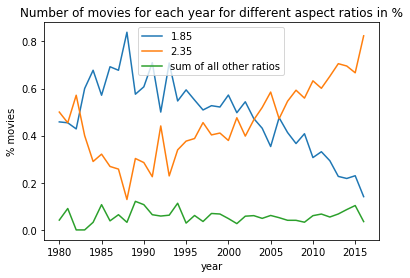

In [14]:
ar_185_perc = year_number_ar[year_number_ar.columns[9]].values
ar_235_perc = year_number_ar[year_number_ar.columns[14]].values
ar_sum_perc = year_number_ar[year_number_ar.columns[21]].values
at_tot = ar_185_perc + ar_235_perc + ar_sum_perc
years = year_number_ar.index.values


plt.plot(years,ar_185_perc/at_tot)
plt.plot(years,ar_235_perc/at_tot)
plt.plot(years,ar_sum_perc/at_tot)
plt.xlabel('year')
plt.ylabel('% movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios in %")
plt.show()

Using percentage we can notice that the 2.35 ratio remains the preveland one. The sum of all other ratios (different form 2.35 and 1.85) remains quite low. Due to the last years' rules for movie companies regarting the ratio (which must be optimal to see the movie at the cinema) we cand srop this column.

In [15]:
movie_data = movie_data.drop('aspect_ratio', axis=1) # drop aspect ratio column

### Country <a name="country"></a>

Firstly, we plot for each country, the number of movies produced there

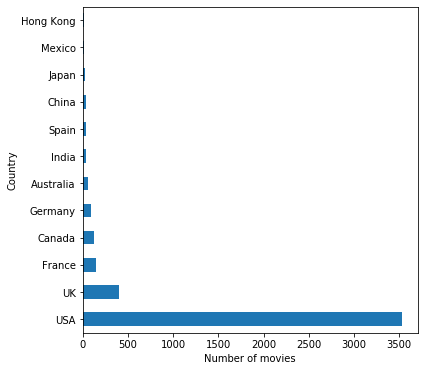

In [16]:
mlb = MultiLabelBinarizer()
country = movie_data.country.values
#encoded_country = pd.DataFrame(country, columns=mlb.classes_, index=movie_df.index)
count_country = Counter(country)
count_country = {k: v for k, v in sorted(count_country.items(), key=lambda item: item[1], reverse = True)}
count_country = dict(itertools.islice(count_country.items(), 12)) 
dd = pd.DataFrame(count_country.items())
dd = dd.set_index(0)

fig, ax = plt.subplots(figsize=(6,6))
dd.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Country')
plt.show()

We have taken our data from different sources and we do not know, for movies which are not American, in which currencies the budget and the gross are. Theoretically, reading the information of our databases, the prices should be all in dollars. However, some movies (as the Japan film 'The Host') are in Yen. 

Hence, considering that the large majority of movies are American and that we suppose to do our analysis for an American company, we can drop all movies which are not produced in USA. In this way we avoid potential and dangerous currency-related mistakes and we can focus on American people tastes.

### 2) Drop Duplicates and Key Values <a name="drop_key"></a>

From the *movie_imdb_link* we extract the IMDB_id.

In [17]:
# extraction of imdb_id 
movie_data['imdb_id'] = movie_data.movie_imdb_link.str.split('/').map(lambda row: row[4])

movie_data = movie_data.drop('movie_imdb_link', axis=1) # drop link column

We noticed that some movies are repeated. So, we cannot just set imdb_id as index: this is not an unique key right now. Before that, we have to delete duplicate rows. 

This is also the first step for the deletion of NaN values. In fact, a lot of NaN values derive from the fact that if a film is present twice, and not both lines have all the values.

In [18]:
print("Number of NaN values for each feature before dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature before dropping doplicate rows:


director_name                  0
num_critic_for_reviews        41
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        619
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                140
num_user_for_reviews          15
language                       5
country                        1
content_rating               255
budget                       375
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

From the DataFrame we delete duplicates movies. In order to do that, we sort our value for the number of NaN and we keep only the copy with the lower number of features with value NaN. 
This should not only delete duplicates, but also reduce the number of NaN for each feature.

In [19]:
movie_data = (
    movie_data.iloc[movie_data.isnull().sum(axis=1).mul(-1).argsort()] # Sort by number of NaN
        .drop_duplicates(subset='imdb_id', keep='last') # Remove duplicates taking last element
)

print("Number of NaN values for each feature after dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature after dropping doplicate rows:


director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

A lot of features have less missing values! This makes our DataFrame more consistent. Moreover, now we have an unique key: imdb_id. Now, we can set it as index.

 It is useful to match this database with the other ones, that we need to fill the NaN values. The reason why we do not use the title to match them is that the title is not an unique key: it can be inconsistent between different data sets (eg. Capitalization). 

We check that this 'imdb_id' is unique and we set it as index:

In [20]:
if movie_data.imdb_id.nunique() == len(movie_data['imdb_id'].values): 
    movie_data = movie_data.set_index('imdb_id') # add imdb_id as a new column

movie_data.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt2638024,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,NaN,...,autism|middle east|music therapy|united arab e...,NaN,Arabic,United Arab Emirates,NaN,125000.0,2013.0,NaN,8.2,54
tt0304692,Harry Gantz,12.0,105.0,0.0,NaN,NaN,NaN,247740.0,Documentary|Drama,NaN,...,bisexual|explicit sex|sex|stranger|swing,8.0,English,USA,NaN,NaN,2002.0,NaN,4.7,51
tt0488873,Andrew Berends,12.0,90.0,0.0,NaN,NaN,NaN,NaN,Documentary|War,NaN,...,american|blood|dream|patrol|tank,7.0,English,USA,NaN,120000.0,2005.0,NaN,6.6,14
tt4462082,Jem Cohen,12.0,111.0,6.0,NaN,NaN,NaN,NaN,Documentary,NaN,...,city|city symphony|diary|essay|surveillance,1.0,English,USA,NaN,50000.0,2015.0,NaN,6.0,5
tt4607906,Valentine,NaN,NaN,0.0,NaN,Valentine,17.0,NaN,Romance,Diane Sorrentino,...,NaN,NaN,English,USA,PG-13,125000.0,2015.0,0.0,5.1,0


### 3) Fill NaN values with other datasets:  <a name="fill_na"></a>

We use these two datasets to fill NaN values
 - Wikipedia dataset
 - TMDb dataset

In [21]:
movie_data.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### Wikipedia  <a name="wikipedia"></a>

We use this dataset to fill NaN values in for these features:

- [Gross](#gross)
- [Budget](#budget)


This is the Wikipedia query that we used to download data:

```
SELECT ?movieLabel (MAX(?grosses) as ?gross) (MIN(?costs) as ?cost) (MIN(?publicationYears) as ?publicationYear) ?IMDBid
WHERE 
{
  ?movie (wdt:P31/wdt:P279*) wd:Q11424;
                             wdt:P345 ?IMDBid;
                             wdt:P2142 ?grosses;
                             wdt:P577 ?publicationDate.
  
  OPTIONAL {?movie wdt:P2130 ?costs.}
  
  BIND(YEAR(?publicationDate) AS ?publicationYears)
  
  FILTER(?publicationYears >= (1980))
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} GROUP BY ?movieLabel ?IMDBid
```

In [22]:
wiki_data = pd.read_csv('data/wiki_data.csv').drop('movieLabel', axis=1).set_index("IMDBid") # read data from the wiki_data csv
wiki_data = wiki_data.rename(columns={"gross":"gross_1"}) #rename gross column
wiki_data = wiki_data.sort_values(axis=0, by="IMDBid")
wiki_data.head()

,gross_1,cost,publicationYear
IMDBid,,,
tt0074486,7000000.0,100000.0,1980
tt0076709,1950391.0,NaN,1981
tt0078788,83471511.0,31500000.0,2019
tt0079417,106000000.0,NaN,1980
tt0080339,83453539.0,3500000.0,1980


In [23]:
# merge the two dataset on the imdb_id
movie_df = movie_data.merge(wiki_data, how='left', left_index=True, right_index=True)

In [24]:
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,gross_1,cost,publicationYear
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt2638024,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,NaN,...,United Arab Emirates,NaN,125000.0,2013.0,NaN,8.2,54,NaN,NaN,NaN
tt0304692,Harry Gantz,12.0,105.0,0.0,NaN,NaN,NaN,247740.0,Documentary|Drama,NaN,...,USA,NaN,NaN,2002.0,NaN,4.7,51,NaN,NaN,NaN
tt0488873,Andrew Berends,12.0,90.0,0.0,NaN,NaN,NaN,NaN,Documentary|War,NaN,...,USA,NaN,120000.0,2005.0,NaN,6.6,14,NaN,NaN,NaN
tt4462082,Jem Cohen,12.0,111.0,6.0,NaN,NaN,NaN,NaN,Documentary,NaN,...,USA,NaN,50000.0,2015.0,NaN,6.0,5,NaN,NaN,NaN
tt4607906,Valentine,NaN,NaN,0.0,NaN,Valentine,17.0,NaN,Romance,Diane Sorrentino,...,USA,PG-13,125000.0,2015.0,0.0,5.1,0,NaN,NaN,NaN


In [25]:
# we added 3 columns:
movie_data.shape, movie_df.shape

((4560, 25), (4560, 28))

Now we have some repeated columns: gross and costs.

We have to keep only one of them. Instead of deleting one without an analysis. we match them in order to delete as many NaN values as possible

**Gross:** <a name="gross"></a>

In [26]:
# gross :   gross from movie dataset
# gorss_1 : gross from wiki dataset

gross_movie_na = movie_df.gross.isna()

for i in range(len(gross_movie_na)): # for each film
    if gross_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.gross[i] = movie_df.gross_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('gross_1', axis=1) # drop link gross wiki column

**Budget:** <a name="budget"></a>

In [27]:
# budget :   cost from movie dataset
# cost :     cost from wiki dataset

cost_movie_na = movie_df.budget.isna()

for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.cost[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['cost','publicationYear'], axis=1) # drop link cost wiki column

Now we can see that the number of movies with empty values in gross and budget has decreased :)

In [28]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       359
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### TMDb  <a name="tmdb"></a>

We repeat the same steps for this dataset, which is used to fill NaN values in
- [Budget](#budget_1)
- [Keywords](#keywords)

In [29]:
tmdb_data = pd.read_csv('data/tmdb_movies_data.csv').set_index("imdb_id") # read data from the wiki_data csv
tmdb_data = tmdb_data.rename(columns={"budget":"budget_1"}) #rename gross column
tmdb_data = tmdb_data[['budget_1','keywords']]

tmdb_data.head()

,budget_1,keywords
imdb_id,,
tt0369610,150000000,monster|dna|tyrannosaurus rex|velociraptor|island
tt1392190,150000000,future|chase|post-apocalyptic|dystopia|australia
tt2908446,110000000,based on novel|revolution|dystopia|sequel|dyst...
tt2488496,200000000,android|spaceship|jedi|space opera|3d
tt2820852,190000000,car race|speed|revenge|suspense|car


In [30]:
movie_df = movie_df.merge(tmdb_data, how='left', left_index=True, right_index=True)
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,budget_1,keywords
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,English,USA,PG-13,48000000.0,2001.0,1000.0,6.4,0,0.0,lover (female)|love of one's life|time travel|...
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,English,USA,PG,3500000.0,1980.0,575.0,7.8,16000,3500000.0,chicago|alcohol|cataclysm|guitar|medicine
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,English,USA,R,4500000.0,1980.0,511.0,5.7,0,4500000.0,sexual identity|shipwreck|lovers|stranded|maro...
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,English,USA,R,27000000.0,1980.0,809.0,7.9,14000,27000000.0,dancing|prison|chicago|country music|nun
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,English,USA,R,6000000.0,1980.0,573.0,7.4,0,6000000.0,golf|underwear|sport|golf course|gopher


**Budget:** <a name="budget_1"></a>

In [31]:
# budget :   cost from movie dataset
# budget_1 :     cost from TDM  dataset

cost_movie_na = movie_df.budget.isna()

for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.budget_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('budget_1', axis=1) # drop link cost wiki column

**Keywords:**  <a name="keywords"></a>

In [32]:
# plot_keywords :    from movie dataset
# keywords :      from TDM  dataset

keywords_movie_na = movie_df.plot_keywords.isna()

for i in range(len(keywords_movie_na)): # for each film
    if keywords_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.plot_keywords[i] = movie_df.keywords[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['keywords'], axis=1) # drop link cost wiki column

In [33]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                129
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       171
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

## 4) Filling or Removing NaN Values  <a name="fill_remove"></a>

In [34]:
# for now we fill gross and budget NaN in this way, then we will fill them in a smarter way
movie_df.gross = movie_df.gross.fillna(movie_df.gross.median())
movie_df.budget = movie_df.budget.fillna(0)

In [35]:
NotFamous = {'actor_2_name': 'No Second Actor', 'actor_1_name': 'No Actor', 'actor_3_name': 'No Third Actor'}
movie_df = movie_df.fillna(value=NotFamous)

NotFBlikes = {'actor_3_facebook_likes': 0, 'actor_2_facebook_likes': 0, 'actor_1_facebook_likes': 0}
movie_df = movie_df.fillna(value=NotFBlikes)

NotRated = {'content_rating': 'Not Rated'}
movie_df = movie_df.fillna(value=NotRated)

In [36]:
# we manually searched for them 
movie_df.loc['tt3949660', 'facenumber_in_poster']=4
movie_df.loc['tt0903624', 'facenumber_in_poster']=1
movie_df.loc['tt3567288', 'facenumber_in_poster']=0
movie_df.loc['tt0989757', 'facenumber_in_poster']=2
movie_df.loc['tt1929263', 'facenumber_in_poster']=0
movie_df.loc['tt3014666', 'facenumber_in_poster']=6

In [37]:
movie_df=movie_df.dropna()
movie_df=movie_df.replace({'content_rating': {'Unrated': 'Not Rated'}})
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,bridge|brooklyn bridge|falling down an elevato...,316.0,English,USA,PG-13,48000000.0,2001.0,1000.0,6.4,0
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,air traffic controller|airplane|airport|pilot|...,427.0,English,USA,PG,3500000.0,1980.0,575.0,7.8,16000
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,coming of age|island|poison|teenage boy|teenag...,140.0,English,USA,R,4500000.0,1980.0,511.0,5.7,0
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,band|catholic|money|parolee|prison,319.0,English,USA,R,27000000.0,1980.0,809.0,7.9,14000
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,caddy|country club|golf course|gopher|nudity,250.0,English,USA,R,6000000.0,1980.0,573.0,7.4,0


In [38]:
movie_df.isna().sum()

director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

# Feature Engineering and pre-data processing   <a name="feature_engineering"></a>

## 1) Genres: One Hot Encoding  <a name="genres"></a>

In [39]:
mlb = MultiLabelBinarizer()
genres = movie_df.genres.str.split("|")
encoded_genres = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_, index=movie_df.index)
encoded_genres

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
tt0080339,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0080453,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
tt0080455,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0080487,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4733536,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
tt4786282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4824308,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


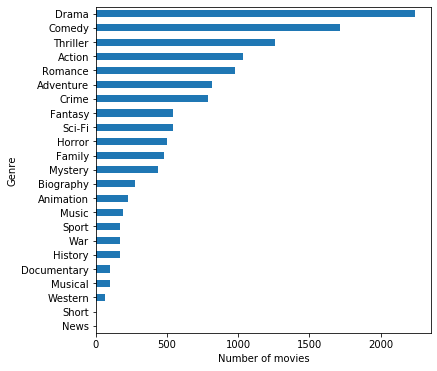

In [40]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

We can group togheter similar genres, in order to decrease the number of columns

In [41]:
# Mystery|Thriller|Horror
sum_gen = encoded_genres[['Mystery','Thriller','Horror']].sum(axis=1)
encoded_genres['Mystery_Thriller_Horror'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Mystery','Thriller','Horror'], axis=1) #drop other

#Sci-Fi|Fantasy
sum_gen = encoded_genres[['Sci-Fi','Fantasy']].sum(axis=1)
encoded_genres['Sci-Fi_Fantasy'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Sci-Fi','Fantasy'], axis=1) #drop other

#Family|Animation
sum_gen = encoded_genres[['Family','Animation']].sum(axis=1)
encoded_genres['Family_Animation'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Family','Animation'], axis=1) #drop other

#Action|Adventure
sum_gen = encoded_genres[['Action','Adventure']].sum(axis=1)
encoded_genres['Action_Adventure'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Action','Adventure'], axis=1) #drop other

#History|War
sum_gen = encoded_genres[['History','War']].sum(axis=1)
encoded_genres['History_War'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['History','War'], axis=1) #drop other


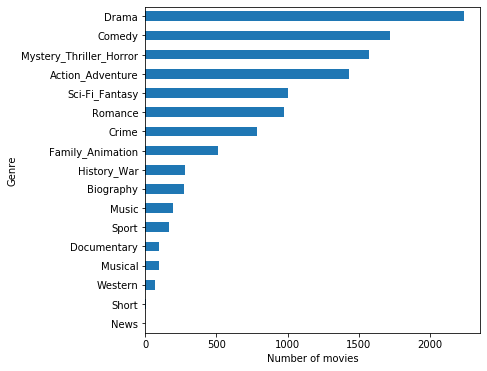

In [42]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

At this point we can put togheter genres which are not common:

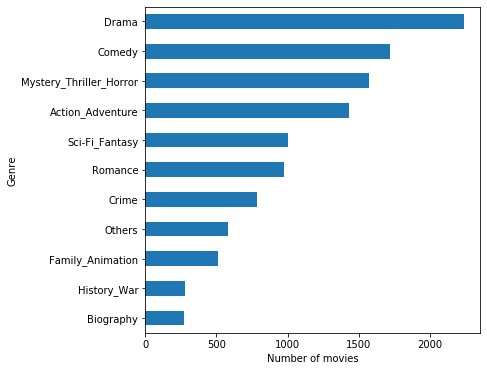

In [43]:
#Other
other = ['Music','Sport','Documentary','Musical','Western','Short','News']

sum_gen = encoded_genres[other].sum(axis=1)
encoded_genres['Others'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(other, axis=1) #drop other

# Add genres columns to movie_df
movie_df = movie_df.merge(encoded_genres,how='left', left_index=True, right_index=True)

count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()


## 2) Rating <a name="rating"></a>

For each director and actor we assign a rank, which considers different features which characterise him/her. It will be useful to identify the most important who contruìibute to the movie.


### Director <a name="genres"></a>

In [44]:
group_director = movie_df.groupby('director_name') # group the database for the director
directors = list(movie_df.director_name.values) #director list
directors_unique =list(OrderedDict.fromkeys(directors)) # no duplicates

#number of movies for each director
#counter = collections.Counter(directors)
results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')
directors.head()

,num_movies
director,
James Mangold,8
Jim Abrahams,1
Randal Kleiser,2
John Landis,3
Harold Ramis,8


In the regression, we cannot use variables which are consequnces, as movie_facebook_likes. However, we can use them to understand how much a director is famous. If a film has a lot of likes, its director will probably earn a good reputation.

Same reasoning for imdb_score

In [45]:
# mean movie_facebook_likes for the movies did by that director
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)

directors.head(10)

,num_movies,imdb_score
director,,
James Mangold,8,7.075000
Jim Abrahams,1,7.800000
Randal Kleiser,2,6.200000
John Landis,3,6.966667
Harold Ramis,8,6.550000
Nancy Walker,1,4.500000
Michael Apted,6,6.516667
Brian De Palma,12,6.683333
David Lynch,4,7.700000


Director:


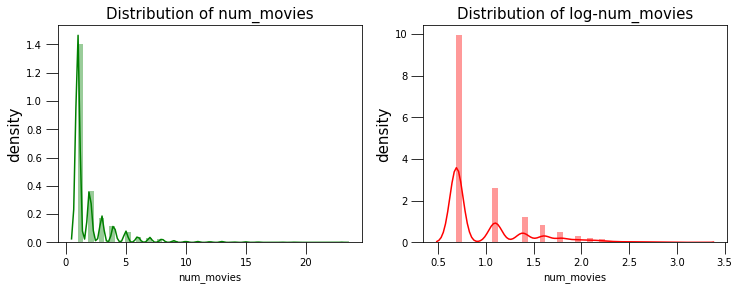

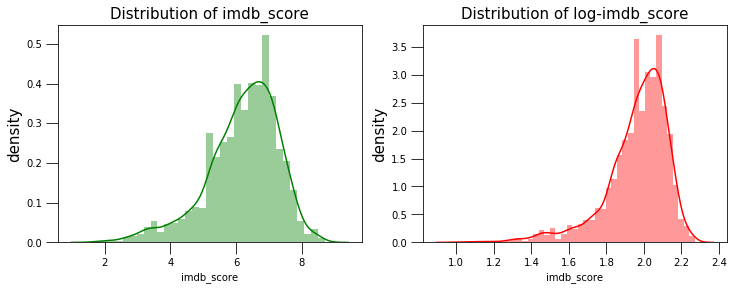

In [46]:
print("Director:")
for col in ["num_movies", "imdb_score"]:
    _, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
    sns.distplot(directors[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(directors[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

Using these three features, we can create a ranking for the directors. We consider 10 levels. If a director is in level 10, he is really important: he has done a lot of movies with high ranking. 

In order to do that, we 
- trasform this variables in values between 0 and 1
- do the mean of each column (same weight for each feature)
- create 10 groups

In [47]:
#we divide wach value for the max of that column in order to have values between 0 and 1
directors.num_movies = directors.num_movies/directors.num_movies.max()

directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/2 + directors.imdb_score*1/2
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]


directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

directors.head(10)

,num_movies,imdb_score,mean_,director_rank
director,,,,
Steven Spielberg,1,0.864068,0.932034,10
Clint Eastwood,0.826087,0.828191,0.827139,8
Woody Allen,0.782609,0.797573,0.790091,8
Martin Scorsese,0.695652,0.880747,0.7882,8
Spike Lee,0.695652,0.755029,0.72534,7
Ridley Scott,0.652174,0.809195,0.730685,7
Renny Harlin,0.652174,0.660536,0.656355,7
Steven Soderbergh,0.652174,0.767816,0.709995,7
Oliver Stone,0.608696,0.798851,0.703773,7


In [48]:
print("Less influent directors:")
directors.sort_values(by=['director_rank']).head()

Less influent directors:


,num_movies,imdb_score,mean_,director_rank
director,,,,
Joe Marino,0.0434783,0.298851,0.171164,1
Terence Young,0.0434783,0.310345,0.176912,1
Joseph Sargent,0.0434783,0.321839,0.182659,1
Vondie Curtis-Hall,0.0434783,0.241379,0.142429,1
Alex Zamm,0.0434783,0.264368,0.153923,1


### Recent movies

In [49]:
movie_recent_df = movie_df[movie_df.title_year>2000]
group_director = movie_recent_df.groupby('director_name') 
directors = list(movie_recent_df.director_name.values) 
directors_unique =list(OrderedDict.fromkeys(directors))

results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')

# mean movie_facebook_likes for the movies did by that director
likes =   group_director.mean().movie_facebook_likes
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)
directors = directors.merge(likes, how='left', left_index=True, right_index=True)
directors.num_movies = directors.num_movies/directors.num_movies.max()
directors.movie_facebook_likes = directors.movie_facebook_likes/directors.movie_facebook_likes.max()
directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/3 + directors.imdb_score*1/3 + directors.movie_facebook_likes*1/3
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]


directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

directors.head(15)

,num_movies,imdb_score,movie_facebook_likes,mean_,director_rank
director,,,,,
Christopher Nolan,0.583333,0.967159,0.860414,0.803636,10
Steven Spielberg,1,0.831418,0.173028,0.668149,8
Clint Eastwood,1,0.844828,0.163298,0.669375,8
Peter Jackson,0.666667,0.913793,0.359733,0.646731,8
Stephen Chbosky,0.0833333,0.919540,1.000000,0.667625,8
Damien Chazelle,0.0833333,0.977011,0.984733,0.681693,8
Woody Allen,0.916667,0.796238,0.109934,0.607613,7
Ridley Scott,0.833333,0.803448,0.275573,0.637451,7
Martin Scorsese,0.583333,0.894910,0.285714,0.587986,7


### Actors <a name="actors"></a>
- [Actor1](#a1)
- [Actor2](#a2)
- [Actor3](#a3)

we do not want to use directly the column of actors_facebook_likes because we would like also to consider how many films they have done. 

**Actor 1** <a name="a1"></a>

In [50]:
# actor_1_name
actor1 = movie_df.groupby('actor_1_name') # group the database for the actor_1_name
actors1 = list(movie_df.actor_1_name.values) #director list
actors1_unique =list(OrderedDict.fromkeys(actors1)) # no duplicates

#number of movies for each actor1
results = [actors1.count(x) for x in actors1_unique] #number of films
actors1 = pd.DataFrame([actors1_unique, results], index=['actors1', 'num_movies']).T
actors1 = actors1.set_index('actors1')

# mean actor_1_facebook_likes for the movies did by that director
num_likes = actor1.mean().actor_1_facebook_likes
actors1 = actors1.merge(num_likes, how='left', left_index=True, right_index=True)

actors1.head(5)

,num_movies,actor_1_facebook_likes
actors1,,
Hugh Jackman,18,20000.0
Peter Graves,1,628.0
Brooke Shields,1,1000.0
John Belushi,1,1000.0
Bill Murray,26,13000.0


Actor1:


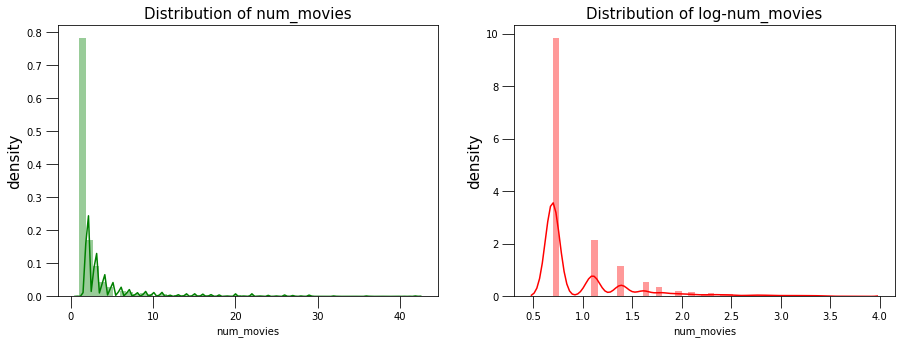

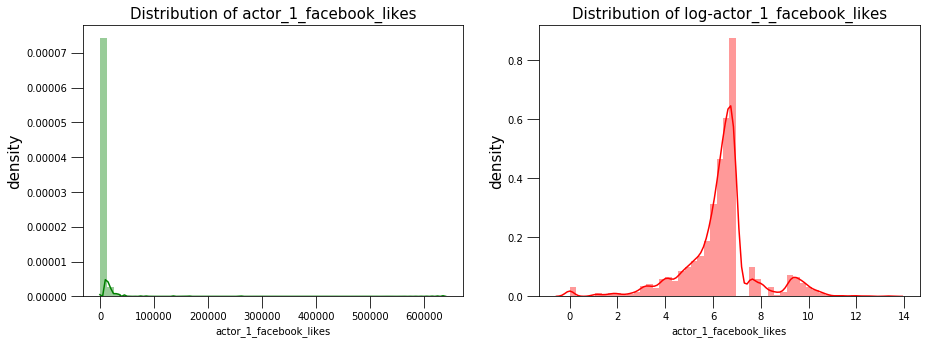

In [51]:
print("Actor1:")
for col in ["num_movies", "actor_1_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors1[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors1[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [52]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors1.num_movies = actors1.num_movies/actors1.num_movies.max()
# log for facebook likes
max_likes = np.log(actors1.actor_1_facebook_likes.max())
actors1.actor_1_facebook_likes = [1 if x == 0 else x for x in actors1.actor_1_facebook_likes.values] # edit zeros to use log
actors1.actor_1_facebook_likes = np.log(actors1.actor_1_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors1['mean_'] = actors1.num_movies*1/2 + actors1.actor_1_facebook_likes*1/2
massimo = actors1.mean_.max()
actors1['actor1_rank'] = [int(x) for x in actors1.mean_/massimo*10]

actors1 = actors1.sort_values(['actor1_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Actor',0,0,0,0]],columns=['actors1','num_movies','actor_1_facebook_likes','mean_','actor1_rank']).set_index('actors1')
actors1 = actors1.append(df2)

In [53]:
actors1.head(10)

,num_movies,actor_1_facebook_likes,mean_,actor1_rank
actors1,,,,
Robert De Niro,1,0.747897,0.873948,10
Johnny Depp,0.857143,0.792614,0.824878,9
Nicolas Cage,0.761905,0.702559,0.732232,8
Denzel Washington,0.690476,0.732887,0.711681,8
J.K. Simmons,0.690476,0.754405,0.722441,8
Matt Damon,0.690476,0.708546,0.699511,8
Robin Williams,0.642857,0.807794,0.725325,8
Bruce Willis,0.666667,0.708546,0.687606,7
Steve Buscemi,0.642857,0.702559,0.672708,7


**Actor 2** <a name="a2"></a>

In [54]:
# actor_2_name
actor2 = movie_df.groupby('actor_2_name') # group the database for the actor_2_name
actors2 = list(movie_df.actor_2_name.values) #director list
actors2_unique =list(OrderedDict.fromkeys(actors2)) # no duplicates

#number of movies for each actor2
results = [actors2.count(x) for x in actors2_unique] #number of films
actors2 = pd.DataFrame([actors2_unique, results], index=['actors2', 'num_movies']).T
actors2 = actors2.set_index('actors2')

# mean actor_2_facebook_likes for the movies did by that director
num_likes = actor2.mean().actor_2_facebook_likes
actors2 = actors2.merge(num_likes,how='left', left_index=True, right_index=True)

actors2.head(5)

,num_movies,actor_2_facebook_likes
actors2,,
Natasha Lyonne,2,1000.0
Lloyd Bridges,1,575.0
Christopher Atkins,1,511.0
Aretha Franklin,1,809.0
Rodney Dangerfield,1,573.0


Actor2:


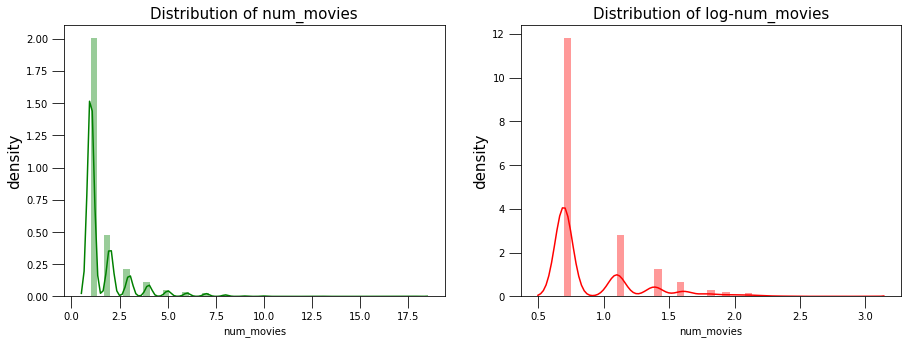

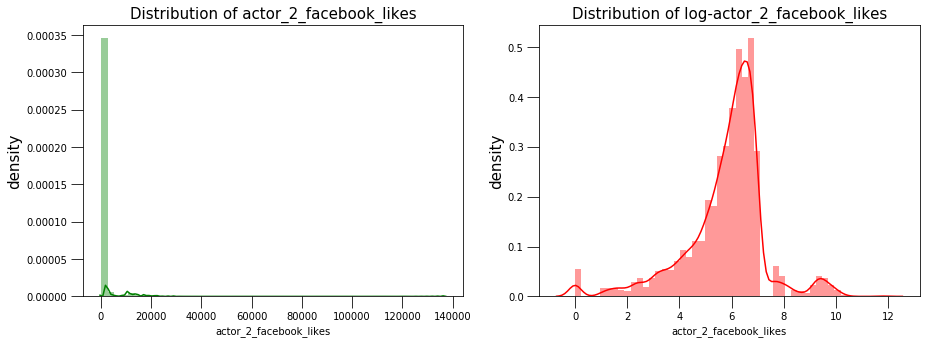

In [55]:
print("Actor2:")
for col in ["num_movies", "actor_2_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors2[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors2[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [56]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors2.num_movies = actors2.num_movies/actors2.num_movies.max()
# log for facebook likes
max_likes = np.log(actors2.actor_2_facebook_likes.max())
actors2.actor_2_facebook_likes = [1 if x == 0 else x for x in actors2.actor_2_facebook_likes.values] # edit zeros to use log
actors2.actor_2_facebook_likes = np.log(actors2.actor_2_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors2['mean_'] = actors2.num_movies*1/2 + actors2.actor_2_facebook_likes*1/2
massimo = actors2.mean_.max()
actors2['actor2_rank'] = [int(x) for x in actors2.mean_/massimo*10]

actors2 = actors2.sort_values(['actor2_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Second Actor',0,0,0,0]],columns=['actors2','num_movies','actor_2_facebook_likes','mean_','actor2_rank']).set_index('actors2')
actors2 = actors2.append(df2)

actors2.head(10)

,num_movies,actor_2_facebook_likes,mean_,actor2_rank
actors2,,,,
Morgan Freeman,1,0.786765,0.893383,10
Charlize Theron,0.777778,0.769799,0.773788,8
Brad Pitt,0.722222,0.786765,0.754494,8
Meryl Streep,0.555556,0.786765,0.67116,7
Adam Sandler,0.555556,0.786765,0.67116,7
James Franco,0.555556,0.786765,0.67116,7
Bruce Willis,0.5,0.800889,0.650445,7
Will Ferrell,0.5,0.759841,0.62992,7
Kate Winslet,0.444444,0.807155,0.6258,7


**Actor 3** <a name="a3"></a>

In [57]:
# actor_3_name
actor3 = movie_df.groupby('actor_3_name') # group the database for the actor_3_name
actors3 = list(movie_df.actor_3_name.values) #director list
actors3_unique =list(OrderedDict.fromkeys(actors3)) # no duplicates

#number of movies for each actor3
results = [actors3.count(x) for x in actors3_unique] #number of films
actors3 = pd.DataFrame([actors3_unique, results], index=['actors3', 'num_movies']).T
actors3 = actors3.set_index('actors3')

# mean actor_3_facebook_likes for the movies did by that director
num_likes = actor3.mean().actor_3_facebook_likes
actors3 = actors3.merge(num_likes,how='left', left_index=True, right_index=True)

actors3.head(5)

,num_movies,actor_3_facebook_likes
actors3,,
Bradley Whitford,1,821.0
Barbara Billingsley,1,318.0
Leo McKern,2,83.0
Ray Charles,1,326.0
Brian Doyle-Murray,2,484.0


Actor3:


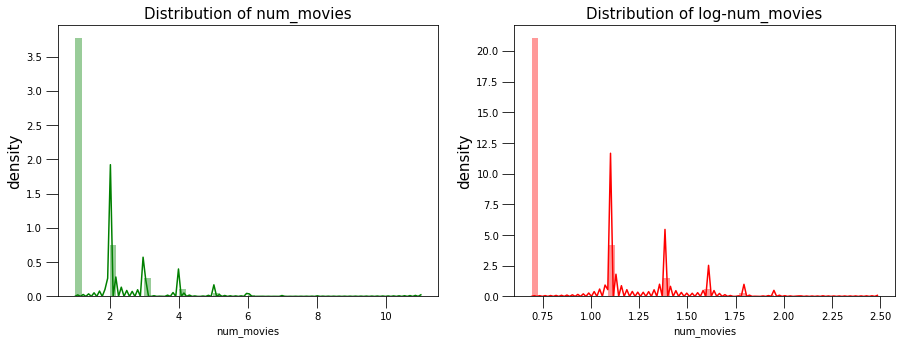

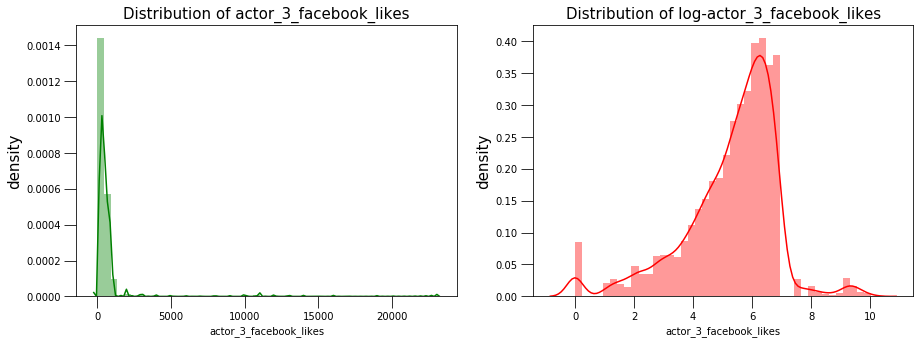

In [58]:
print("Actor3:")
for col in ["num_movies", "actor_3_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors3[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors3[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [59]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors3.num_movies = actors3.num_movies/actors3.num_movies.max()
# log for facebook likes
max_likes = np.log(actors3.actor_3_facebook_likes.max())
actors3.actor_3_facebook_likes = [1 if x == 0 else x for x in actors3.actor_3_facebook_likes.values] # edit zeros to use log
actors3.actor_3_facebook_likes = np.log(actors3.actor_3_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors3['mean_'] = actors3.num_movies*1/2 + actors3.actor_3_facebook_likes*1/2
massimo = actors3.mean_.max()
actors3['actor3_rank'] = [int(x) for x in actors3.mean_/massimo*10]

actors3 = actors3.sort_values(['actor3_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Third Actor',0,0,0,0]],columns=['actors3','num_movies','actor_3_facebook_likes','mean_','actor3_rank']).set_index('actors3')
actors3 = actors3.append(df2)

actors3.head()

,num_movies,actor_3_facebook_likes,mean_,actor3_rank
actors3,,,,
Anne Hathaway,0.545455,0.926558,0.736006,10
Steve Coogan,0.727273,0.687801,0.707537,9
Kirsten Dunst,0.545455,0.825833,0.685644,9
Steve Carell,0.545455,0.881554,0.713504,9
Gary Oldman,0.454545,0.917068,0.685807,9


Add director and actors ratings to movie_df:

In [60]:
movie_df['imdb_id'] = movie_df.index
movie_df = pd.merge(left=movie_df, right=directors.director_rank , left_on='director_name', right_on='director')
movie_df = pd.merge(left=movie_df, right=actors1.actor1_rank , left_on='actor_1_name', right_on='actors1')
movie_df = pd.merge(left=movie_df, right=actors2.actor2_rank , left_on='actor_2_name', right_on='actors2')
movie_df = pd.merge(left=movie_df, right=actors3.actor3_rank , left_on='actor_3_name', right_on='actors3')

movie_df = movie_df.sort_values(by='imdb_id').drop_duplicates(subset='imdb_id', keep='last').set_index('imdb_id')
movie_df

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,0,1,0,0,0,0,5,6,3,5
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,0,0,0,0,0,1,3,7,3,5
tt0080549,Michael Apted,46.0,124.0,150.0,572.0,Beverly D'Angelo,874.0,79900000.0,Biography|Drama|Music|Musical,Sissy Spacek,...,0,0,0,0,0,1,4,3,4,4
tt0080661,Brian De Palma,121.0,104.0,0.0,517.0,David Margulies,754.0,31899000.0,Mystery|Romance|Thriller,Angie Dickinson,...,1,0,0,0,0,0,3,2,3,4
tt0080678,David Lynch,117.0,124.0,0.0,452.0,Anne Bancroft,12000.0,26010864.0,Biography|Drama,Anthony Hopkins,...,0,0,0,0,0,0,4,6,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4733536,Nick Love,16.0,86.0,63.0,175.0,Christopher Berry,489.0,25003072.0,Action|Comedy|Drama|Sci-Fi,Eddie Griffin,...,0,1,0,1,0,0,3,3,2,4
tt4786282,David F. Sandberg,159.0,81.0,26.0,300.0,Amiah Miller,2000.0,56536016.0,Horror,Billy Burke,...,1,0,0,0,0,0,3,3,3,5
tt4824308,Harold Cronk,29.0,120.0,18.0,295.0,Robin Givens,634.0,20773070.0,Drama,Benjamin A. Onyango,...,0,0,0,0,0,0,1,2,3,4


## 2b) Rating Recent Movies <a name="rat_new"></a>

In this section we searched for the most famous actor and the most prominent director after 2000. 

In [61]:
movie_recent_df = movie_df[movie_df.title_year>2000] # select movies after 2000

**Director**

In [62]:
group_director = movie_recent_df.groupby('director_name') 
directors = list(movie_recent_df.director_name.values) 
directors_unique =list(OrderedDict.fromkeys(directors))

results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')

# mean movie_facebook_likes for the movies did by that director
likes =   group_director.mean().movie_facebook_likes
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)
directors = directors.merge(likes, how='left', left_index=True, right_index=True)
directors.num_movies = directors.num_movies/directors.num_movies.max()
directors.movie_facebook_likes = directors.movie_facebook_likes/directors.movie_facebook_likes.max()
directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/3 + directors.imdb_score*1/3 + directors.movie_facebook_likes*1/3
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]

directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

string_dir = color.BOLD + directors.index[0] + color.END
print(f"The most prominent director after 2000 is {string_dir}")

The most prominent director after 2000 is Christopher Nolan


**Actor 1** <a name="a1"></a>

In [63]:
# actor_1_name
actor1 = movie_recent_df.groupby('actor_1_name') # group the database for the actor_1_name
actors1 = list(movie_recent_df.actor_1_name.values) #director list
actors1_unique =list(OrderedDict.fromkeys(actors1)) # no duplicates

#number of movies for each actor1
results = [actors1.count(x) for x in actors1_unique] #number of films
actors1 = pd.DataFrame([actors1_unique, results], index=['actors1', 'num_movies']).T
actors1 = actors1.set_index('actors1')

# mean actor_1_facebook_likes for the movies did by that director
num_likes = actor1.mean().actor_1_facebook_likes
actors1 = actors1.merge(num_likes, how='left', left_index=True, right_index=True)

#we divide wach value for the max of that column in order to have values between 0 and 1
actors1.num_movies = actors1.num_movies/actors1.num_movies.max()
# log for facebook likes
max_likes = np.log(actors1.actor_1_facebook_likes.max())
actors1.actor_1_facebook_likes = [1 if x == 0 else x for x in actors1.actor_1_facebook_likes.values] # edit zeros to use log
actors1.actor_1_facebook_likes = np.log(actors1.actor_1_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors1['mean_'] = actors1.num_movies*1/2 + actors1.actor_1_facebook_likes*1/2
massimo = actors1.mean_.max()
actors1['actor1_rank'] = [int(x) for x in actors1.mean_/massimo*10]

actors1 = actors1.sort_values(['actor1_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Actor',0,0,0,0]],columns=['actors1','num_movies','actor_1_facebook_likes','mean_','actor1_rank']).set_index('actors1')
actors1 = actors1.append(df2)

string_act = color.BOLD + actors1.index[0] + color.END
print(f"The most prominent director after 2000 is {string_act}")

The most prominent director after 2000 is Johnny Depp


## 4) Fill Missed Budget Values <a name="missed_budget"></a>

In this section we fil missed values for the budget

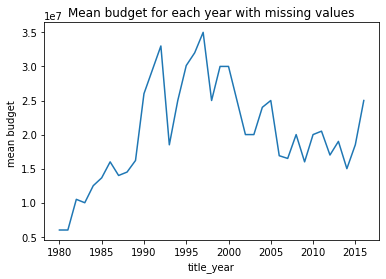

In [64]:
# Mean budget for each year with missing values

grouped_by_year = movie_df.groupby("title_year").budget.median()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean budget ")
plt.title("Mean budget for each year with missing values")
plt.show()

Even if the mean of budgets of each year is not zero, it can happens that the budget of some movies is zero (this means that the value was missed and we replaced it with zero)

In [65]:
# missed values
zero_budget = (movie_df.budget == 0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 246


For each movie we have a rank of its director and its cast. These elements are the ones which influence most the movie's budget. Another feature which influence the cost of a movie is the genre. We will rank every movie considering cast/director and its genre

**cast/director**

In [66]:
# rank for the cast considering its 3 actors rank
fill_budget_df = movie_df[['actor1_rank','actor2_rank','actor3_rank']]

In [67]:
# the protagonist has a bigger weight than others: 50% first actor, 30% second actor, 20% third actor
fill_budget_df['rank_cast'] = fill_budget_df.actor1_rank * 0.5 + fill_budget_df.actor2_rank * 0.30 + fill_budget_df.actor2_rank * 0.2
fill_budget_df.head()

,actor1_rank,actor2_rank,actor3_rank,rank_cast
imdb_id,,,,
tt0035423,6,3,5,4.5
tt0080487,7,3,5,5.0
tt0080549,3,4,4,3.5
tt0080661,2,3,4,2.5
tt0080678,6,4,5,5.0


In [68]:
fill_budget_df = fill_budget_df.drop(columns= ['actor1_rank','actor2_rank','actor3_rank'])
fill_budget_df['director_rank'] = movie_df.director_rank
fill_budget_df.head()

,rank_cast,director_rank
imdb_id,,
tt0035423,4.5,5
tt0080487,5.0,3
tt0080549,3.5,4
tt0080661,2.5,3
tt0080678,5.0,4


**genre**

Some genres requires a bigger investment. We found some articles which proves that (see Report). In particular, the most expensive are
- Action_Adventure
- Sci-Fi_Fantasy
- History_War

Average 65 milion

Then there is
- Animation

Average 60 milion

Others have a mean of 20 milion.

Then we can assign to each movie a rank based on genre average cost:

In [69]:
movie_genres = movie_df[[
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War','Others']]

movie_genres.to_csv('data/data_genre.csv')

movie_genres.head()

,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others
imdb_id,,,,,,,,,,,
tt0035423,0,1,0,0,1,0,1,0,0,0,0
tt0080487,0,1,0,0,0,0,0,0,0,0,1
tt0080549,1,0,0,1,0,0,0,0,0,0,1
tt0080661,0,0,0,0,1,1,0,0,0,0,0
tt0080678,1,0,0,1,0,0,0,0,0,0,0


In [70]:
genre_rank = []

for i in range(len(movie_genres)): #for each movie
    index = movie_genres.index[i]
    rowData = movie_genres.loc[ index , : ] # all genres of one movie
    
    if rowData.Action_Adventure==1 or rowData['Sci-Fi_Fantasy']==1 or rowData.History_War==1 :
        genre_rank.append(1)
    elif rowData.Family_Animation==1 :
        genre_rank.append(round(float(60/65),2))
    else :
        genre_rank.append(round(float(60/65),2))


In [71]:
fill_budget_df['genre_rank'] = genre_rank
fill_budget_df = fill_budget_df.sort_values('director_rank', ascending=False) #sort values

# scale 0-1 also for rank_cast and director_rank
fill_budget_df.rank_cast = fill_budget_df.rank_cast/fill_budget_df.rank_cast.max()
fill_budget_df.director_rank = [round(float(x),2) for x in fill_budget_df.director_rank]
fill_budget_df.director_rank = fill_budget_df.director_rank/fill_budget_df.director_rank.max()


Warning!!!! remember to comment that this is a ranking of importance. it does not mean that the costs are 0.3 0.3 0.3

We suppose each is equally important:

In [72]:
fill_budget_df['rank_for_budget'] = fill_budget_df.mean(axis=1)
fill_budget_df.head()

,rank_cast,director_rank,genre_rank,rank_for_budget
imdb_id,,,,
tt0372784,0.65,1.0,1.00,0.883333
tt0468569,0.65,1.0,1.00,0.883333
tt1375666,0.60,1.0,1.00,0.866667
tt0278504,0.40,1.0,0.92,0.773333
tt1345836,0.55,1.0,1.00,0.850000


In [73]:
fill_budget_df = fill_budget_df.drop(columns= ['rank_cast','director_rank','genre_rank'])
fill_budget_df['budget'] = movie_df.budget
fill_budget_df = fill_budget_df.sort_values('rank_for_budget', ascending=False) #sort values
fill_budget_df.head()

,rank_for_budget,budget
imdb_id,,
tt1057500,0.900000,60000000.0
tt0372784,0.883333,150000000.0
tt0468569,0.883333,185000000.0
tt0482571,0.866667,40000000.0
tt0118607,0.866667,36000000.0


Now each film has a rank of features which influence the budget. Keep all of them would be too complicate, then we identify a rank of 20 values.


In [74]:
massimo = fill_budget_df.rank_for_budget.max()
fill_budget_df['rank_for_budget_integer'] = [int(x) for x in fill_budget_df.rank_for_budget/massimo*2*10]
fill_budget_df.head()

,rank_for_budget,budget,rank_for_budget_integer
imdb_id,,,
tt1057500,0.900000,60000000.0,20
tt0372784,0.883333,150000000.0,19
tt0468569,0.883333,185000000.0,19
tt0482571,0.866667,40000000.0,19
tt0118607,0.866667,36000000.0,19


In [75]:
# mean of each rank of budget, ignoring movies with missing budget (which would bias the mean)

# ignore zero budget movies
movies_with_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget==0].index)
movies_with_budget_df = movies_with_budget_df.drop(columns='rank_for_budget')
data = movies_with_budget_df.groupby(movies_with_budget_df.rank_for_budget_integer)
data = data.mean()
data.head()

,budget
rank_for_budget_integer,
7,1.100000e+06
8,7.212500e+06
9,6.648255e+06
10,2.178331e+07
11,2.816008e+07


Now for each rank (no movies under rank = 7) we have the mean of its movies. We can assign this value of budget to movies with missing budget

In [76]:
movies_missing_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget>0].index)
movies_missing_budget_df = movies_missing_budget_df.drop(columns='rank_for_budget')
movies_missing_budget_df.head()

,budget,rank_for_budget_integer
imdb_id,,
tt0319829,0.0,14
tt0119051,0.0,14
tt0893382,0.0,13
tt0455499,0.0,13
tt1172570,0.0,13


In [77]:
print(f"We check that they are actually {len(movies_missing_budget_df)} movies")

We check that they are actually 246 movies


In [78]:
# fill values
for i in range(len(movies_missing_budget_df)):
    index = movies_missing_budget_df.index[i]
    rowData = movies_missing_budget_df.loc[ index , : ] # all genres of one movie
    rank_movie = int(rowData.rank_for_budget_integer)
    
    budget_movie =  data.loc[ rank_movie , : ].budget

    movie_df.update(
        movie_df.loc[movie_df.index == index, 'budget'].replace(0.0, budget_movie, regex=True)
    )

In [79]:
# we should have filled all zero budget values. check:
zero_budget = (movie_df.budget==0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 0


## 4) Gross Budget Ratio  <a name="ratio"></a>

We create the gross budget ratio feature, an important feature to understand the profitability of the movies. Note that the creation of this variable does not cause any probles because we have substitue every zero budget values in the [Filling Missed Budget Values](#missed_budget) part.

In [80]:
movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget

# Exploratory Data Analysis (EDA) All movies  <a name="eda"></a>


## 1) Univariate Analysis <a name="uni"></a>

### Some high-level observations <a name="high_level"></a>

Firstly, we plot a general description of our data:

In [81]:
movie_df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank,gross_budget_ratio
count,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000,3.966000e+03,3.966000e+03,3966.000000,3966.000000,3966.000000,...,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000
mean,156.002521,108.126576,737.732980,706.133384,7375.525719,4.785363e+07,9.304042e+04,10872.025466,1.400908,295.587746,...,0.222642,0.116994,0.319213,0.064297,0.132123,3.840898,3.942007,3.380484,4.517398,8.689927
std,123.516388,21.246351,2947.447455,1783.490418,15949.037026,6.876485e+07,1.450373e+05,19308.720843,2.074560,393.473976,...,0.416073,0.321454,0.466231,0.245311,0.338667,1.328000,1.976958,1.380539,1.597310,130.490720
min,1.000000,14.000000,0.000000,0.000000,0.000000,6.180800e+01,5.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000017
25%,65.000000,94.000000,8.000000,157.000000,680.000000,7.446117e+06,1.238425e+04,1621.750000,0.000000,79.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,4.000000,0.446382
50%,128.000000,104.000000,54.000000,405.000000,1000.000000,2.500307e+07,4.263250e+04,3638.000000,1.000000,175.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000,3.000000,5.000000,1.108586
75%,215.000000,118.000000,214.000000,664.000000,12000.000000,5.838524e+07,1.098888e+05,15389.750000,2.000000,361.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,5.000000,4.000000,5.000000,2.372303
max,813.000000,330.000000,23000.000000,23000.000000,640000.000000,1.200264e+09,1.689764e+06,656730.000000,43.000000,5060.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,7194.485533


### distribution
Distribution of the main numerical features of the data set
Due  the  right-skewed  of  the  distribution  of  budget  andgross earning, it is appropriate to consider the log trasformation of these variables

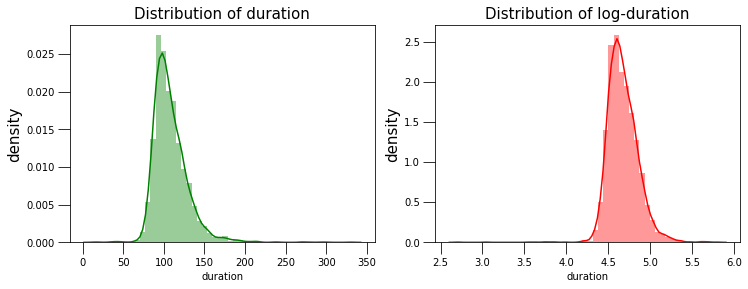

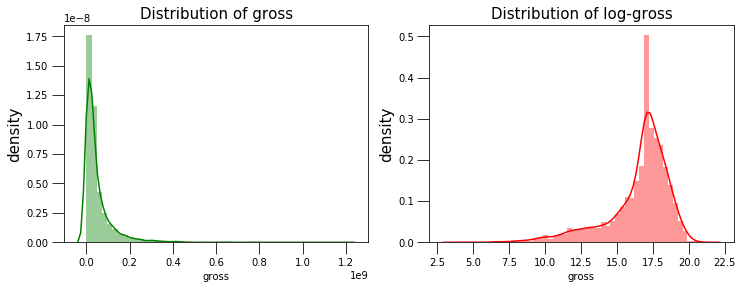

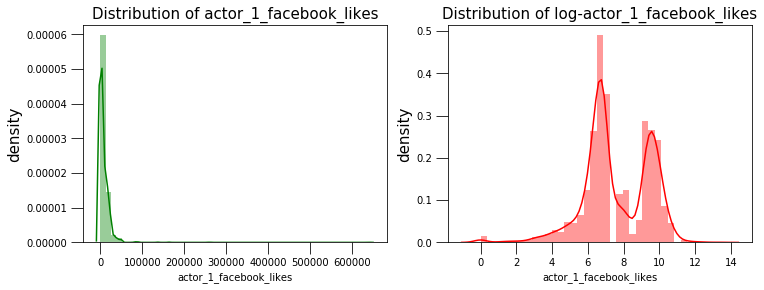

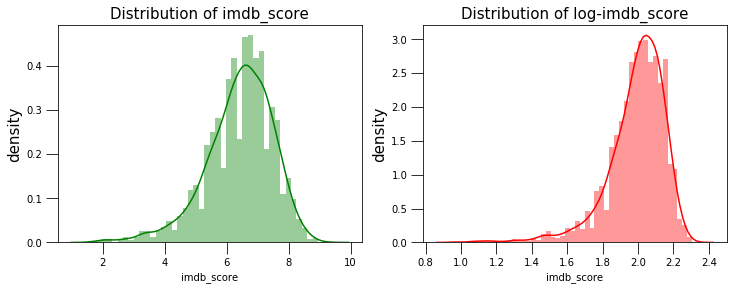

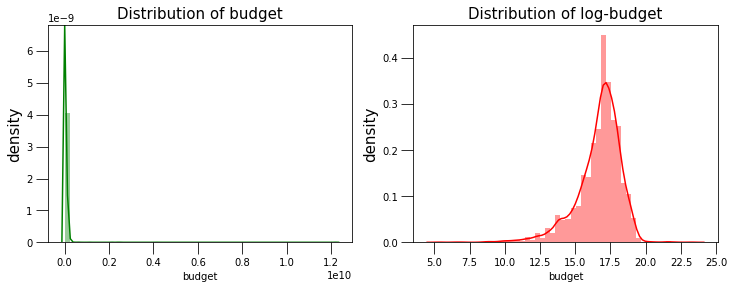

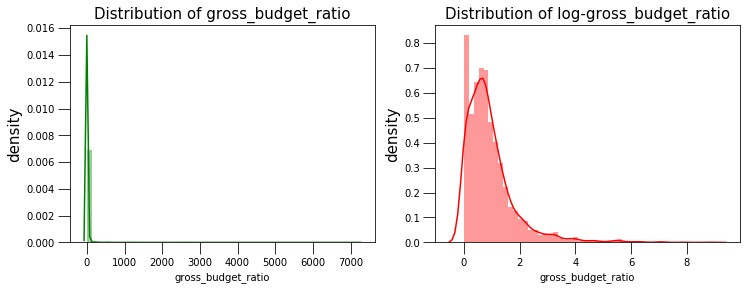

In [82]:



for col in ["duration", "gross", "actor_1_facebook_likes","imdb_score","budget","gross_budget_ratio"]:
    
    _, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
    sns.distplot(movie_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movie_df[col].fillna(0) + 1), color="r", ax=ax2)
    
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
        
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

we can see that distribution of budget and gross of movies are not so explanatory. This is due to the fact the the data sets includes both boxoffice movies and documentaries that have a significant difference in marketing and financial needs.
So it might be interesting to look at the number of movies by genre. 


#### Summary statistics of relevant variables

In [83]:
grossde=movie_df['gross'].describe()
budgetde=movie_df['budget'].describe()
ratiogb=movie_df['gross_budget_ratio'].describe()
profitde=(movie_df['gross']-movie_df['budget']).describe()
summary = pd.DataFrame([grossde,budgetde,profitde,ratiogb]).T
summary.columns.values[2] = "profits"
summary#summary statistics of relevant variables

,gross,budget,profits,gross_budget_ratio
count,3.966000e+03,3.966000e+03,3.966000e+03,3966.000000
mean,4.785363e+07,4.322898e+07,4.624658e+06,8.689927
std,6.876485e+07,2.193372e+08,2.233179e+08,130.490720
min,6.180800e+01,2.180000e+02,-1.221330e+10,0.000017
25%,7.446117e+06,9.000000e+06,-1.103094e+07,0.446382
50%,2.500307e+07,2.380000e+07,1.611380e+06,1.108586
75%,5.838524e+07,4.867173e+07,2.320307e+07,2.372303
max,1.200264e+09,1.221550e+10,1.174264e+09,7194.485533


### SP500 and FED <a name="fed"></a>

Now, we plot the **SP 500** (see Report for details) for a comparison with the global economy

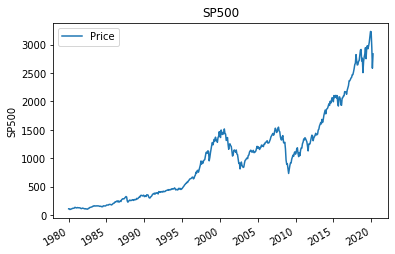

In [84]:
sp500 = (pd.read_csv(r'data/SeP500.csv')).iloc[::-1]
index = pd.period_range(start="01-01-1980", end="04-01-2020", freq="M")
sp500.index=index
sp500['Price'] = sp500['Price'].str.replace(',', '')
sp500['Price'] = sp500['Price'].astype(float)
sp500price=sp500.Price.resample("A").mean()
sp500.plot(x_compat=True)
plt.title("SP500") # fra check the title
plt.ylabel("SP500")
plt.show()

**FED**

Interest rate as index of required return

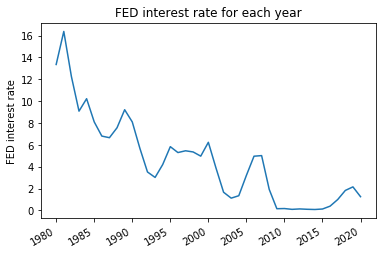

In [85]:
fed = (pd.read_csv(r'data/fed.csv'))#.iloc[::-1]

index = pd.period_range(start="01-01-1980", end="03-01-2020", freq="M")
fed.index=index

fed['FEDFUNDS'] = fed['FEDFUNDS'].astype(float)
fedrate=fed.FEDFUNDS.resample("A").mean()
fedrate.plot(x_compat=True)
plt.ylabel("FED interest rate")
plt.title("FED interest rate for each year")
plt.show()

### Trends mean gross/budget ratio overtime

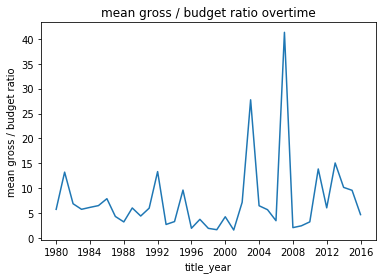

In [86]:

movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget
grouped_by_year = movie_df.groupby("title_year").gross_budget_ratio.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean gross / budget ratio")
plt.xticks(np.arange(min(grouped_by_year.index), max(grouped_by_year.index)+1, 4))
plt.title("mean gross / budget ratio overtime")
plt.show()

In [87]:
movie_df.loc[movie_df.title_year==2007].sort_values(by=['gross_budget_ratio'])


,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank,gross_budget_ratio
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0887719,Scott Marshall,20.0,93.0,7.0,611.0,Drew Waters,906.0,5561.0,Comedy|Romance,Drew Fuller,...,0,0,0,0,0,2,3,3,7,0.000556
tt0484111,Jake Paltrow,50.0,93.0,17.0,66.0,Gael Le Cornec,1000.0,20380.0,Comedy|Drama|Fantasy|Music|Romance,Stephen Graham,...,1,0,0,0,1,3,3,2,3,0.001359
tt0952682,Jeff Nichols,85.0,92.0,337.0,22.0,Natalie Canerday,35.0,45661.0,Drama|Thriller,Michael Abbott Jr.,...,0,0,0,0,0,5,1,1,2,0.001621
tt0861739,José Padilha,142.0,115.0,294.0,15.0,Fernanda Machado,585.0,8060.0,Action|Crime|Drama|Thriller,Wagner Moura,...,0,0,1,0,0,5,3,2,2,0.002015
tt0913968,Peter Ho-Sun Chan,106.0,113.0,31.0,483.0,Takeshi Kaneshiro,5000.0,128978.0,Action|Drama|History|Romance|War,Jet Li,...,0,0,1,1,0,3,4,3,4,0.003224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0825346,Richard Schenkman,6.0,90.0,29.0,558.0,Mike Colter,1000.0,25003072.0,Comedy|Romance,Vanessa Williams,...,0,0,0,0,0,4,3,3,4,25.281165
tt0907657,John Carney,232.0,85.0,109.0,18.0,Markéta Irglová,200.0,9437933.0,Drama|Music|Romance,Glen Hansard,...,0,0,0,0,1,5,2,2,2,52.432961
tt0756683,Richard Schenkman,66.0,87.0,29.0,131.0,John Billingsley,505.0,25003072.0,Drama|Romance|Sci-Fi,William Katt,...,1,0,0,0,0,4,2,3,3,125.015360


## 2) Bivariate Analysis <a name="biv"></a>
 
With this analysis we want to find out the relationship between a factor with the two indicators of a film's success: profitability and IMDB score.



### Relationship between profitability and IMDB score <a name="prof_imdb"></a>

In [88]:
movies_with_valid_profit = movie_df[movie_df.gross_budget_ratio<=20]

### Correlation imdb_score and gross_budget_ratio

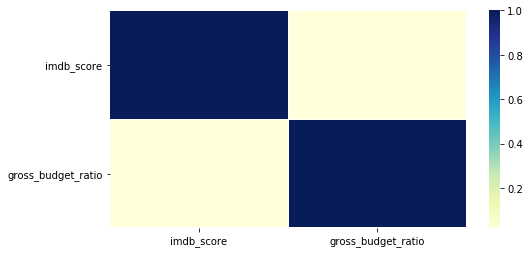

In [89]:
# again, don't see much influence here (between what?)

pivot=movie_df[['imdb_score',"gross_budget_ratio"]]
pivot=pivot[pivot.gross_budget_ratio<=20]
corp = pivot.apply(lambda x: pd.factorize(x)[0])#scaling 
corp=corp.corr()
plt.figure(figsize=(8, 4))
ax = sns.heatmap(corp, xticklabels=corp.columns, yticklabels=corp.columns, 
                 linewidths=.2, cmap="YlGnBu")
plt.yticks(rotation=0)  
plt.show()

In [90]:
## finction for writing the correlation explicitely in the pairplot
def cor(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 15, xycoords = ax.transAxes)
    

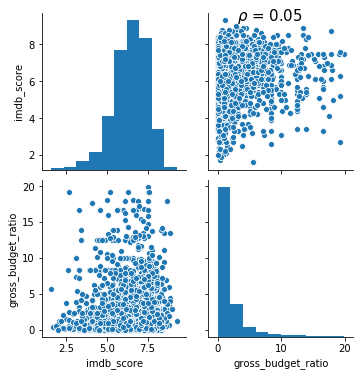

In [91]:
grid=sns.pairplot(data=movie_df[movie_df.gross_budget_ratio<=20], vars=["imdb_score", "gross_budget_ratio"])
grid = grid.map_upper(cor)

If we remove the outliers of profitability ratio, we see that to have a profitability ratio higher than 5, a movie must have an IMDb score of 4 and above.

In [92]:
movies_with_imdb_classmean=[]
movies_with_imdb_classmean.append(movie_df[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].gross_budget_ratio.mean())
movies_with_imdb_classmean.append(movie_df[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].gross_budget_ratio.mean()) 

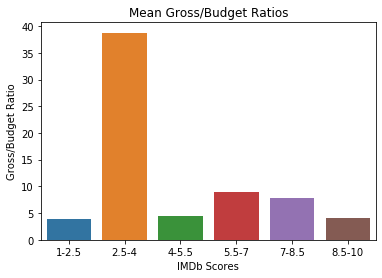

In [93]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean)
plt.xticks(rotation=0)
plt.ylabel("Gross/Budget Ratio")
plt.xlabel('IMDb Scores')
plt.title(f"Mean Gross/Budget Ratios")
plt.show()

In [94]:
movies_with_gb_classmean=[]
movies_with_gb_classmean.append(movie_df[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].imdb_score.mean())
movies_with_gb_classmean.append(movie_df[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(20<movie_df.gross_budget_ratio)].imdb_score.mean())

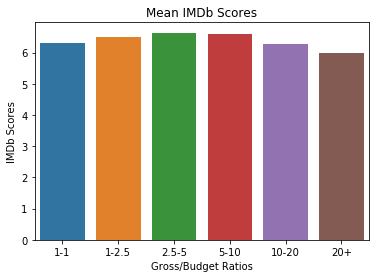

In [95]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean)
plt.xticks(rotation=0)
plt.ylabel("IMDb Scores")
plt.xlabel('Gross/Budget Ratios')
plt.title(f"Mean IMDb Scores")
plt.show()

### Average Gross Budget Ratio For Each Genre <a name="ratio_genre"></a>

In [96]:
gen_df = movie_df[['gross_budget_ratio','budget', 'gross']] 

movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

gen_df = gen_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

genr = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']
column=['gross_budget_ratio']
prof_gen = pd.DataFrame(index=genr, columns=column)
for gen in genr:
  ab = gen_df.loc[gen_df[gen]==1]
  ab = ab.gross_budget_ratio.mean() 
  prof_gen['gross_budget_ratio'][gen]= ab


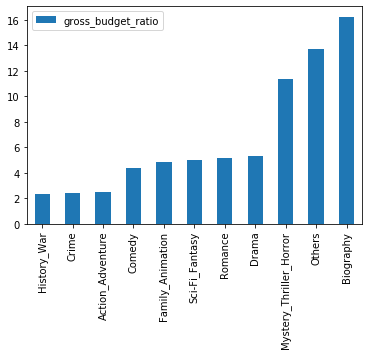

In [97]:
prof_gen=prof_gen.sort_values(by=['gross_budget_ratio'])
prof_gen.plot.bar()

## 3) Multivariate Analysis <a name="multi"></a>

## influnce of ranks on profitability


In [98]:
datara=movie_df[['imdb_score','director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio']]      
#datara = datara.apply(lambda x: pd.factorize(x)[0])
corre=datara.corr()

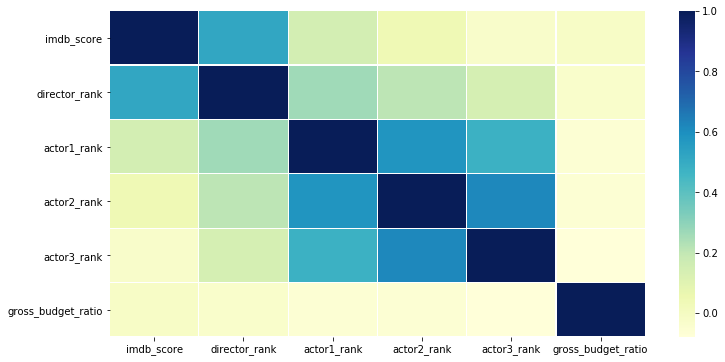

In [99]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(corre, xticklabels=corre.columns, yticklabels=corre.columns, 
                 linewidths=.2, cmap="YlGnBu")

we can see that on average the rank of the director and cast does not have an  impact on profitability. However, it is still worth check if this is a trend that is valid also fot top directors and actors since they are a significant part of the budget of a movie

### Influence of Social Media? <a name="social"></a>


In [100]:
datapi=movie_df[["cast_total_facebook_likes", "movie_facebook_likes", "director_facebook_likes",'imdb_score',"gross_budget_ratio","title_year"]]
datapi=datapi.loc[datapi.title_year>2009]
datapi=datapi.drop("title_year", axis=1)
datapi = datapi.apply(lambda x: pd.factorize(x)[0])
core=datapi.corr()


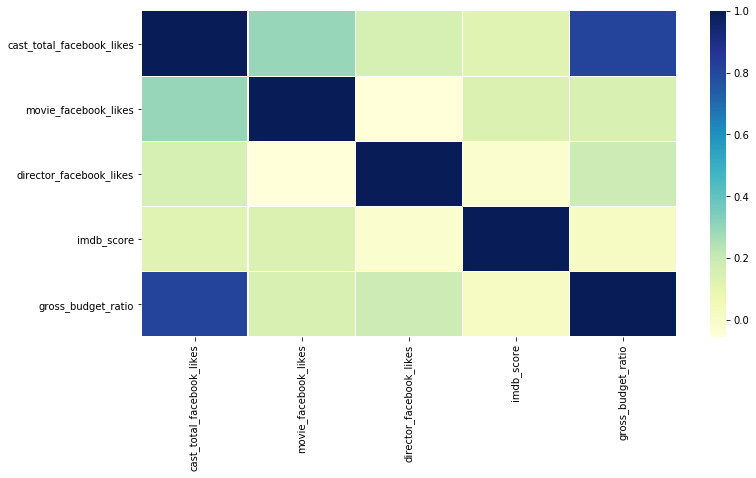

In [101]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(core, xticklabels=core.columns, yticklabels=core.columns, 
                 linewidths=.2, cmap="YlGnBu")

Here, we realize that IMDb score and movie facebook likes might be related. Hence, we analyze these two variables.

In [102]:
movies_with_imdb_classmean2=[]
movies_with_imdb_classmean2.append(datapi[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].cast_total_facebook_likes.mean())
movies_with_imdb_classmean2.append(datapi[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].cast_total_facebook_likes.mean()) 

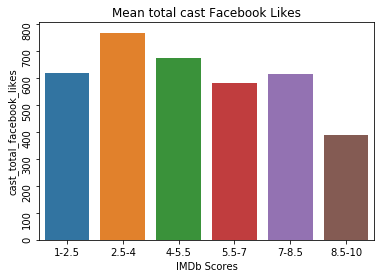

In [103]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast_total_facebook_likes")
plt.xlabel('IMDb Scores')
plt.title(f"Mean total cast Facebook Likes")
plt.yticks(rotation=90)
plt.show()

In [104]:
movies_with_gb_classmean2=[]
movies_with_gb_classmean2.append(datapi[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].cast_total_facebook_likes.mean())
movies_with_gb_classmean2.append(datapi[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(20<movie_df.gross_budget_ratio)].cast_total_facebook_likes.mean())

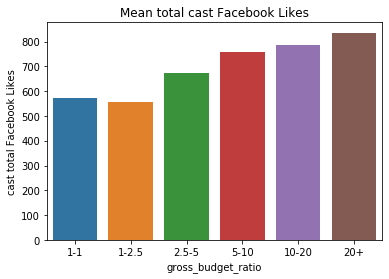

In [105]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast total Facebook Likes")
plt.xlabel('gross_budget_ratio')
plt.title(f"Mean total cast Facebook Likes")
plt.show()


### 3. Effect of Genre on Profitability and IMDb Score

### I. Profitability

In [106]:
##using genres_col,
GenreProf = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War','Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].mean()
GenreNumber = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War', 'Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].count()

In [107]:
Genrestable = GenreProf.to_frame()
Genrestable1 = Genrestable.reset_index()
Genrestable2 = Genrestable1.sort_values(by=['gross_budget_ratio'],ascending=False)

In [108]:
GenreNumber1 = GenreNumber.reset_index()

GenreNumber2 = GenreNumber1.reindex(Genrestable2.index)

In [109]:
Genrestable2

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
181,1,0,0,0,0,0,1,0,1,0,0,12.501536
28,0,0,0,0,1,0,0,1,1,1,1,10.001229
209,1,0,0,0,1,1,0,0,1,0,0,9.395195
238,1,0,1,0,0,0,1,0,0,0,0,8.530000
5,0,0,0,0,0,0,0,1,0,1,0,8.047961
...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,0,1,0,1,0,1,0,0,0,0,0.012206
127,0,0,1,1,1,1,0,0,0,0,0,0.007442
94,0,0,1,0,1,0,0,0,1,1,1,0.001359
69,0,0,1,0,0,0,0,0,1,0,1,0.001218


In [110]:
GenreNumber2

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
181,1,0,0,0,0,0,1,0,1,0,0,1
28,0,0,0,0,1,0,0,1,1,1,1,1
209,1,0,0,0,1,1,0,0,1,0,0,1
238,1,0,1,0,0,0,1,0,0,0,0,1
5,0,0,0,0,0,0,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,0,1,0,1,0,1,0,0,0,0,1
127,0,0,1,1,1,1,0,0,0,0,0,1
94,0,0,1,0,1,0,0,0,1,1,1,1
69,0,0,1,0,0,0,0,0,1,0,1,1


From the 2 dataframe above, we see that 3 movies with genres Drama,Crime and Romance together achieved 5.3 gross/budget ratio. However, since number of movies are low it might be due to some outlier. Hence, we try to analyze highest number of movies with the same genre combination.

In [111]:
GenreNumber3=GenreNumber2.sort_values(by=['gross_budget_ratio'],ascending=False)
Genrestable3 = Genrestable2.reindex(GenreNumber3.index)

In [112]:
GenreNumber3

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
15,0,0,0,0,1,0,0,0,0,0,0,162
3,0,0,0,0,0,0,0,1,0,0,0,160
88,0,0,1,0,1,0,0,0,0,0,0,157
90,0,0,1,0,1,0,0,0,0,1,0,156
64,0,0,1,0,0,0,0,0,0,0,0,155
...,...,...,...,...,...,...,...,...,...,...,...,...
283,1,1,0,0,0,0,0,0,0,0,0,1
166,0,1,1,1,1,0,0,1,0,1,0,1
11,0,0,0,0,0,1,0,0,1,0,0,1
10,0,0,0,0,0,1,0,0,0,0,1,1


In [113]:
Genrestable3

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
15,0,0,0,0,1,0,0,0,0,0,0,1.822991
3,0,0,0,0,0,0,0,1,0,0,0,3.954018
88,0,0,1,0,1,0,0,0,0,0,0,2.080593
90,0,0,1,0,1,0,0,0,0,1,0,2.319489
64,0,0,1,0,0,0,0,0,0,0,0,2.244205
...,...,...,...,...,...,...,...,...,...,...,...,...
283,1,1,0,0,0,0,0,0,0,0,0,1.128571
166,0,1,1,1,1,0,0,1,0,1,0,1.137931
11,0,0,0,0,0,1,0,0,1,0,0,1.210078
10,0,0,0,0,0,1,0,0,0,0,1,1.254668


Here, we see that at the top 4 places all combinations have more than 140 movies. Hence, we can comment more confidently. We see that all of the for segments include Drama in it and all of them has gross/budget ratio of 2 which is a nice number for film makers. By looking at the data, we can say that:
1. Drama + Others ~ 1.7
2. Drama + Comedy + Romance ~2.4
3. Drama Only ~ 1.8
4. Drama + Comedy ~2

Hence, it might be logical to make a drama movie with some comedy and romance in it.

### Let's look at films from a prominent director  <a name="prominent_director"></a>

cambia il titolo e fai una mini spiegazione introduttiva di cosa fai in questa sezione

In [114]:
director = "Christopher Nolan" # change this variable if you want to look into another director
director_films = movie_df.query(f"director_name == '{director}'").sort_values(by="title_year")
genres_col={'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others'}

In [115]:
## genres of films directed and years in which a movie has been released
sums=director_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(director_films.title_year.value_counts())
print("\n")

Genres' counter



NameError: name 'genres_col' is not defined

### Gross budget levels overtime

In [ ]:
director_titles_years = director_films["title_year"].map(int).map(str) + " - " + director_films["movie_title"].map(str)  
graph=director_films["budget"].to_frame()
graph['gross_budget_ratio']=director_films["gross_budget_ratio"]
graph['gross']=director_films["gross"]
graph.index=director_titles_years

ax = plt.subplot(111)
ax2= ax.twinx()
graph.gross_budget_ratio.plot(ax=ax2, style='g-', secondary_y=True, legend='ratio')
plt.ylabel("gross-budget ratio")
graph.plot(ax=ax,y=["budget", "gross"], kind="bar")
plt.ylabel("gross and budget ")
ax.tick_params(axis='x', rotation=90)
leg = ax.get_legend()
leg.remove()        # remove it from ax
ax2.add_artist(leg) # add it to ax2
leg._set_loc(2)
plt.title("Gross budget levels overtime")
plt.show()

In [ ]:
grouped_by_yearn = movie_df.groupby("title_year").gross_budget_ratio.mean()
grouped_by_yearn = grouped_by_yearn[grouped_by_yearn.index.isin(director_films.title_year)]
grouped_by_yearn=grouped_by_yearn.to_frame()
grouped_by_yearn.index=graph.index

grouped_by_yearn.rename(columns={"gross_budget_ratio": "gross_budget_ratio_mean"}, inplace=True)
grouped_by_yearn['gross_budget_ratio_nolan']=graph.gross_budget_ratio
ax = plt.subplot(111)
grouped_by_yearn.plot(ax=ax,y=["gross_budget_ratio_mean",'gross_budget_ratio_nolan'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title("Gross budget ratio compared to average dataset")
plt.show()

### cast total facebook likes for films of our porminient director

In [ ]:
grouped_by_yearn = movie_df.groupby("title_year").cast_total_facebook_likes.mean()
grouped_by_yearn = grouped_by_yearn[grouped_by_yearn.index.isin(director_films.title_year)]
grouped_by_yearn=grouped_by_yearn.to_frame()
grouped_by_yearn.index=graph.index
subdata=director_films
subdata.index=graph.index
grouped_by_yearn.rename(columns={"cast_total_facebook_likes": "cast_total_facebook_likes_mean"}, inplace=True)
grouped_by_yearn['cast_total_facebook_likes_nolan']=subdata.cast_total_facebook_likes
ax = plt.subplot(111)
grouped_by_yearn.plot(ax=ax,y=["cast_total_facebook_likes_mean",'cast_total_facebook_likes_nolan'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"cast total facebook likes for films of {director}")
plt.show()

### IMDB Score for films of our porminient director

In [ ]:
grouped_by_yearn = movie_df.groupby("title_year").imdb_score.mean()
grouped_by_yearn = grouped_by_yearn[grouped_by_yearn.index.isin(director_films.title_year)]
grouped_by_yearn=grouped_by_yearn.to_frame()
grouped_by_yearn.index=graph.index
subdata=director_films
subdata.index=graph.index
grouped_by_yearn.rename(columns={"imdb_score": "imdb_score_mean"}, inplace=True)
grouped_by_yearn['imdb_score_nolan']=subdata.imdb_score
ax = plt.subplot(111)
grouped_by_yearn.plot(ax=ax,y=["imdb_score_mean",'imdb_score_nolan'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"cast total facebook likes for films of {director}")
plt.show()

## Analysis for a prominent actor 

in order to test the validity on the results in the EDA also for top ranked actors is relevant check if the same trends can be found for a prominent actor

In [ ]:
actor = "Johnny Depp" # change this variable if you want to look into another director
actor_films = movie_df.query(f"actor_1_name == '{actor}'").sort_values(by="title_year")


In [ ]:
## genres of films in which the actor has appeared as main actor and years in which a movie has been released
sums=actor_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(actor_films.title_year.value_counts())
print("\n")

### Gross budget levels overtime

In [ ]:
actor_titles_years = actor_films["title_year"]
graph=actor_films["budget"].to_frame()
graph['gross_budget_ratio']=actor_films["gross_budget_ratio"]
graph['gross']=actor_films["gross"]
graph.index=actor_titles_years
graph=graph.groupby(graph.index).mean()
dataj=movie_df[['gross_budget_ratio','title_year']]
dataj=dataj.loc[dataj['gross_budget_ratio']<25.372]
grouped_by_yearj = dataj.groupby("title_year").gross_budget_ratio.mean()
grouped_by_yearj = grouped_by_yearj[grouped_by_yearj.index.isin(actor_films.title_year)]
grouped_by_yearj=grouped_by_yearj.to_frame()
grouped_by_yearj.index=graph.index

grouped_by_yearj.rename(columns={"gross_budget_ratio": "gross_budget_ratio_mean"}, inplace=True)
grouped_by_yearj['gross_budget_ratio_depp']=graph.gross_budget_ratio
ax = plt.subplot(111)
grouped_by_yearj.plot(ax=ax,y=["gross_budget_ratio_mean",'gross_budget_ratio_depp'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title("Gross budget ratio compared to average dataset")
plt.show()


In [ ]:
actor_titles_years = actor_films["title_year"]
graph=actor_films["cast_total_facebook_likes"].to_frame()
graph.index=actor_titles_years
graph=graph.groupby(graph.index).mean()
dataj=movie_df[['cast_total_facebook_likes','title_year']]
grouped_by_yearj = dataj.groupby("title_year").cast_total_facebook_likes.mean()
grouped_by_yearj = grouped_by_yearj[grouped_by_yearj.index.isin(actor_films.title_year)]
grouped_by_yearj=grouped_by_yearj.to_frame()
grouped_by_yearj.index=graph.index

grouped_by_yearj.rename(columns={"cast_total_facebook_likes": "cast_total_facebook_likes_mean"}, inplace=True)
grouped_by_yearj['cast_total_facebook_likes_depp']=graph.cast_total_facebook_likes
ax = plt.subplot(111)
grouped_by_yearj.plot(ax=ax,y=["cast_total_facebook_likes_mean",'cast_total_facebook_likes_depp'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"cast total facebook likes for films with {actor} compared to dataset average ")
plt.show()

In [ ]:
actor_titles_years = actor_films["title_year"]
graph=actor_films["imdb_score"].to_frame()
graph.index=actor_titles_years
graph=graph.groupby(graph.index).mean()
dataj=movie_df[['imdb_score','title_year']]
grouped_by_yearj = dataj.groupby("title_year").imdb_score.mean()
grouped_by_yearj = grouped_by_yearj[grouped_by_yearj.index.isin(actor_films.title_year)]
grouped_by_yearj=grouped_by_yearj.to_frame()
grouped_by_yearj.index=graph.index

grouped_by_yearj.rename(columns={"imdb_score": "imdb_score_mean"}, inplace=True)
grouped_by_yearj['imdb_score_depp']=graph.imdb_score
ax = plt.subplot(111)
grouped_by_yearj.plot(ax=ax,y=["imdb_score_mean",'imdb_score_depp'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"IMDb score for films with {actor} compared to dataset average ")
plt.show()

## 3) Keyword Analysis <a name="keys"></a>

In [ ]:
# words_df is a ataframe which contains what we need for the keyword analysis
words_df =[]
words_df = movie_df[['plot_keywords','budget', 'gross']] 

# a list with all the plot keywords for each movie
words = words_df.plot_keywords
words = [x.split("|") for x in words]


for i in range(len(words_df.plot_keywords)): # for each movie
    
    words[i] = [x.split() for x in words[i]] # splitted words of that movie 
    w = []
    
    # delete sub list in order to have one list for each movie and one one list for each word for each movie
    for j in range(len(words[i])):
        for k in range(len(words[i][j])):
            if len(words[i][j][k])>2 and ' ' not in words[i][j][k]:
                w.append(words[i][j][k])
    
    words[i] = w
    
    # delete duplicates
    words[i] = list(OrderedDict.fromkeys(words[i])) 

In [ ]:
words_df.plot_keywords = words
words_df.head()

In [ ]:
# we need the genre of each movie

movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

words_df = words_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

words_df.head()

### Relation between keywords, Budget, Gross and profitability <a name="rel_keys"></a>

In [ ]:
genres = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']

for genre in genres: # for each genre
    
    print(color.BOLD + genre + color.END +":")
    print('\n')
    
    column = words_df[genre]
    
    words_genre_df = words_df[column==1]
    
    words_genre = []
    
    num_film_word = [0]*len(words_genre_df) # num of movies of that genre in which that word appears
    
    # delete sub list
    for j in range(len(words_genre_df)):
        for k in range(len(words_genre_df.plot_keywords[j])):
            if len(words_genre_df.plot_keywords[j][k])>2 and ' ' not in words_genre_df.plot_keywords[j][k]:
                words_genre.append(words_genre_df.plot_keywords[j][k])
                
    
    # list of all words of this genre:
    words_genre = list(dict.fromkeys(words_genre)) 
    
    budget_word = [0] * len(words_genre)
    gross_word = [0] * len(words_genre)
    num_film_word = [0] * len(words_genre)
    
    #for each word of that genre see the mean budget and mean gross of all movies of that genre which contain this word:
    
    for i in range(len(words_genre)):
        word = words_genre[i]
        budget_word[i] = 0
        gross_word[i] = 0
        
        
        for j in range(len(words_genre_df)): # for  all films of that genre
            
            words_movie = words_genre_df.plot_keywords[j]
            
            
            if word in words_movie:
                num_film_word[i] = num_film_word[i] + 1
                budget_word[i] = budget_word[i] + words_genre_df.budget[j]
                gross_word[i] = gross_word[i] + words_genre_df.gross[j]
        
        if num_film_word[i] > 2: # no if zero (not find) or an exception (only one/two)
            
            # compute the means:
            budget_word[i] = budget_word[i]/num_film_word[i]
            gross_word[i] = gross_word[i]/num_film_word[i]
            
        else: 
            words_genre[i] = 0

    #words_genre = [i for i in words_genre if i != 0]
        
    
    # create a dataframe for each genre
    word_budget_df = pd.DataFrame([words_genre,budget_word, gross_word, num_film_word]).T
    word_budget_df = word_budget_df.rename(columns={0:"word", 1:"mean_budget", 2:"mean_gross", 3:"num_film_word"})
    word_budget_df = word_budget_df[word_budget_df.word != 0]
    word_budget_df = word_budget_df[word_budget_df.num_film_word >3] # only words which appear in more than 3 movies
    word_budget_df = word_budget_df.set_index('word')
    word_budget_df["gross_budget_ratio"] = word_budget_df.mean_gross / word_budget_df.mean_budget
    
    # print results
    print("Order by budget:")
    display(word_budget_df.sort_values('mean_budget', ascending=False)[['mean_budget', 'num_film_word']].head(10)) #order by budget
    print("\n")
    print("Order by gross:")
    display(word_budget_df.sort_values('mean_gross', ascending=False)[['mean_gross', 'num_film_word']].head(10)) #order by budget
    print("\n")
    print("Order by ratio:")
    display(word_budget_df.sort_values('gross_budget_ratio', ascending=False)[['gross_budget_ratio', 'num_film_word']].head(10)) #order by budget
    print("\n")
    

### PCA <a name="pca"></a>

In [ ]:
words_df = movie_df[['plot_keywords']]
words = words_df.plot_keywords
words = [x.split("|") for x in words]
words = [" ".join(x) for x in words]

print(f"number of movies:{len(words_df)}")

words_df.head()

In [ ]:
print(f"List of keywords for the first 5 movies:")
words[0:5]

In [ ]:
count_model = TfidfVectorizer(ngram_range=(1,1))
v = count_model.fit_transform(words)

Xc = (v * v.T ) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
X = Xc.todense()
print(X.shape)

In [ ]:
v.shape

In [ ]:
# target 
movie_genre_df = pd.read_csv(r'data/data_genre.csv')

target = []

# assign only one genre to each movie (the most influent one)
for i in range(len(movie_genre_df)):
    index = movie_genre_df.index[i]
    rowData = movie_genre_df.loc[ index , : ]
    
    if rowData.Drama==1 :
        target.append('Drama')
    elif rowData.Comedy==1 :
        target.append('Comedy')
    elif rowData.Mystery_Thriller_Horror==1 :
        target.append('Mystery_Thriller_Horror')
    elif rowData.Action_Adventure==1 :
        target.append('Action_Adventure')
    elif rowData['Sci-Fi_Fantasy']==1 :
        target.append('Sci-Fi_Fantasy')
    elif rowData.Romance==1 :
        target.append('Romance')
    elif rowData.Crime==1 :
        target.append('Crime')
    elif rowData.Family_Animation==1 :
        target.append('Family_Animation')
    else :
        target.append('Other')
        
# colors 
colors = []

for i in range(9):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

target_no_dup = list(dict.fromkeys(target))
dic_tar_col = dict(zip(target_no_dup,colors))
dic_tar_col

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

com1 = principalComponents[:,0]
com2 = principalComponents[:,1]

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

ax.scatter(com1, com2
               , s = 50)
    
ax.legend(list(dic_tar_col.keys()))
ax.grid()

In [ ]:
len(target)

In [ ]:
len(principalComponents)

In [ ]:
finalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf['Target'] = target

# one row for each movie
finalDf.head()

In [ ]:
pca.explained_variance_

In [ ]:
pca.components_

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

for i in range(len(dic_tar_col)):
    t = list(dic_tar_col.keys())[i]
    cc = dic_tar_col.get(t)
    
    indicesToKeep = finalDf['Target'] == t
    
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = cc
               , s = 50)

coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]

for i in range(n):
    plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
    plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')


##### Getting data to be used in prediction to csv file

In [ ]:
movie_df.to_csv('data/data_regression.csv')


Ideas variables regression:

- budget, duration, director/actors facebook likes, genres
- budget, duration, director/actors facebook rank, genres
-macroeconimcs factors: SP500 and Fed rate
important to see the difference between likes and rank, what work in a better way!
After that maybe we can try to add some post- features. it is important to add them only after because they are consequences:
num_voted_users, 'facenumber_in_poster, num_user_for_reviews, imdb_score, movie_facebook_likes



# Exploratory Data Analysis (EDA) American Movies  <a name="edaam"></a>


## Drop non ameriacn movies

In [ ]:
movie_df = movie_df[movie_df.country == 'USA'] # keep only usa movies

movie_df = movie_df.drop(columns='country') # drop country column

## 1) Univariate Analysis <a name="uni"></a>

### Some high-level observations <a name="high_level"></a>

Firstly, we plot a general description of our data:

In [ ]:
movie_df.describe()

### distribution
Distribution of the main numerical features of the data set
Due  the  right-skewed  of  the  distribution  of  budget  andgross earning, it is appropriate to consider the log trasformation of these variables

In [ ]:
for col in ["duration", "gross", "actor_1_facebook_likes","imdb_score","budget","gross_budget_ratio"]:
    
    _, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
    sns.distplot(movie_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movie_df[col].fillna(0) + 1), color="r", ax=ax2)
    
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
        
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

we can see that distribution of budget and gross of movies are not so explanatory. This is due to the fact the the data sets includes both boxoffice movies and documentaries that have a significant difference in marketing and financial needs.
So it might be interesting to look at the number of movies by genre. 


#### Summary statistics of relevant variables

In [ ]:
grossde=movie_df['gross'].describe()
budgetde=movie_df['budget'].describe()
ratiogb=movie_df['gross_budget_ratio'].describe()
profitde=(movie_df['gross']-movie_df['budget']).describe()
summary = pd.DataFrame([grossde,budgetde,profitde,ratiogb]).T
summary.columns.values[2] = "profits"
summary#summary statistics of relevant variables

### SP500 and FED <a name="fed"></a>

Now, we plot the **SP 500** (see Report for details) for a comparison with the global economy

In [ ]:
sp500 = (pd.read_csv(r'data/SeP500.csv')).iloc[::-1]
index = pd.period_range(start="01-01-1980", end="04-01-2020", freq="M")
sp500.index=index
sp500['Price'] = sp500['Price'].str.replace(',', '')
sp500['Price'] = sp500['Price'].astype(float)
sp500price=sp500.Price.resample("A").mean()
sp500.plot(x_compat=True)
plt.title("SP500") # fra check the title
plt.ylabel("SP500")
plt.show()

**FED**

Interest rate as index of required return

In [ ]:
fed = (pd.read_csv(r'data/fed.csv'))#.iloc[::-1]

index = pd.period_range(start="01-01-1980", end="03-01-2020", freq="M")
fed.index=index

fed['FEDFUNDS'] = fed['FEDFUNDS'].astype(float)
fedrate=fed.FEDFUNDS.resample("A").mean()
fedrate.plot(x_compat=True)
plt.ylabel("FED interest rate")
plt.title("FED interest rate for each year")
plt.show()

### Trends mean gross/budget ratio overtime

In [ ]:

movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget
grouped_by_year = movie_df.groupby("title_year").gross_budget_ratio.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean gross / budget ratio")
plt.xticks(np.arange(min(grouped_by_year.index), max(grouped_by_year.index)+1, 4))
plt.title("mean gross / budget ratio overtime")
plt.show()

### Let's look at films from a prominent director  <a name="prominent_director"></a>

cambia il titolo e fai una mini spiegazione introduttiva di cosa fai in questa sezione

In [ ]:
director = "Christopher Nolan" # change this variable if you want to look into another director
director_films = movie_df.query(f"director_name == '{director}'").sort_values(by="title_year")
director_films.columns
genres_col={'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others'}

Guys there is a function which do the one hot encoding :)

In [ ]:
##using genres_col
sums=director_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(director_films.title_year.value_counts())
print("\n")

##### profitability - budget-gross ratio

### Gross budget levels overtime

In [ ]:
director_titles_years = director_films["title_year"].map(int).map(str) + " - " + director_films["movie_title"].map(str)  
graph=director_films["budget"].to_frame()
graph['gross_budget_ratio']=director_films["gross_budget_ratio"]
graph['gross']=director_films["gross"]
graph.index=director_titles_years

ax = plt.subplot(111)
ax2= ax.twinx()
graph.gross_budget_ratio.plot(ax=ax2, style='g-', secondary_y=True, legend='ratio')
plt.ylabel("gross-budget ratio")
graph.plot(ax=ax,y=["budget", "gross"], kind="bar")
plt.ylabel("gross and budget ")
ax.tick_params(axis='x', rotation=90)
leg = ax.get_legend()
leg.remove()        # remove it from ax
ax2.add_artist(leg) # add it to ax2
leg._set_loc(2)
plt.title("Gross budget levels overtime")
plt.show()

## trends overtime of budget and gross in absulute figures


### Gross-budget ratio for films of our porminient director

In [ ]:
sns.barplot(director_titles_years, director_films["gross_budget_ratio"])
plt.xticks(rotation=90)
plt.ylabel("gross-budget ratio")
plt.title(f"Gross-budget ratio for films of {director}")
plt.show()

### cast total facebook likes for films of our porminient director

In [ ]:
sns.barplot(director_titles_years, director_films.cast_total_facebook_likes)
plt.xticks(rotation=90)
plt.ylabel("cast_total_facebook_likes")
plt.title(f"cast total facebook likes for films of {director}")
plt.show()

### IMDB Score for films of our porminient director

In [ ]:
sns.barplot(director_titles_years, director_films.imdb_score)
plt.xticks(rotation=90)
plt.ylabel("imdb score")
plt.title(f"IMDB Score for films of {director}")
plt.show()

## 2) Bivariate Analysis <a name="biv"></a>
 
With this analysis we want to find out the relationship between a factor with the two indicators of a film's success: profitability and IMDB score.



### Relationship between profitability and IMDB score <a name="prof_imdb"></a>

In [ ]:
movies_with_valid_profit = movie_df[movie_df.gross_budget_ratio<=20]

### Correlation imdb_score and gross_budget_ratio

In [ ]:
# again, don't see much influence here (between what?)

pivot=movie_df[['imdb_score',"gross_budget_ratio"]]
pivot=pivot[pivot.gross_budget_ratio<=20]
corp = pivot.apply(lambda x: pd.factorize(x)[0])#scaling 
corp=corp.corr()
plt.figure(figsize=(8, 4))
ax = sns.heatmap(corp, xticklabels=corp.columns, yticklabels=corp.columns, 
                 linewidths=.2, cmap="YlGnBu")
plt.yticks(rotation=0)  
plt.show()

In [ ]:
## finction for writing the correlation explicitely in the pairplot
def cor(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 15, xycoords = ax.transAxes)
    

In [ ]:
grid=sns.pairplot(data=movie_df[movie_df.gross_budget_ratio<=20], vars=["imdb_score", "gross_budget_ratio"])
grid = grid.map_upper(cor)

If we remove the outliers of profitability ratio, we see that to have a profitability ratio higher than 5, a movie must have an IMDb score of 4 and above.

In [ ]:
movies_with_imdb_classmean=[]
movies_with_imdb_classmean.append(movie_df[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].gross_budget_ratio.mean())
movies_with_imdb_classmean.append(movie_df[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].gross_budget_ratio.mean()) 

In [ ]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean)
plt.xticks(rotation=0)
plt.ylabel("Gross/Budget Ratio")
plt.xlabel('IMDb Scores')
plt.title(f"Mean Gross/Budget Ratios")
plt.show()

In [ ]:
movies_with_gb_classmean=[]
movies_with_gb_classmean.append(movie_df[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].imdb_score.mean())
movies_with_gb_classmean.append(movie_df[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(20<movie_df.gross_budget_ratio)].imdb_score.mean())

In [ ]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean)
plt.xticks(rotation=0)
plt.ylabel("IMDb Scores")
plt.xlabel('Gross/Budget Ratios')
plt.title(f"Mean IMDb Scores")
plt.show()

### Average Gross Budget Ratio For Each Genre <a name="ratio_genre"></a>

In [ ]:
gen_df = movie_df[['gross_budget_ratio','budget', 'gross']] 

movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

gen_df = gen_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

genr = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']
column=['gross_budget_ratio']
prof_gen = pd.DataFrame(index=genr, columns=column)
for gen in genr:
  ab = gen_df.loc[gen_df[gen]==1]
  ab = ab.gross_budget_ratio.mean() 
  prof_gen['gross_budget_ratio'][gen]= ab


In [ ]:
prof_gen=prof_gen.sort_values(by=['gross_budget_ratio'])
prof_gen.plot.bar()

## 3) Multivariate Analysis <a name="multi"></a>

In [ ]:
## influnce of Ranks

### Influence of Social Media? <a name="social"></a>


In [ ]:
movie_df.columns

In [ ]:
datapi=movie_df[["cast_total_facebook_likes", "movie_facebook_likes", "director_facebook_likes",'imdb_score',"gross_budget_ratio","title_year"]]
datapi=datapi.loc[datapi.title_year>2009]
datapi=datapi.drop("title_year", axis=1)
datapi = datapi.apply(lambda x: pd.factorize(x)[0])
core=datapi.corr()


In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(core, xticklabels=core.columns, yticklabels=core.columns, 
                 linewidths=.2, cmap="YlGnBu")

Here, we realize that IMDb score and movie facebook likes might be related. Hence, we analyze these two variables.

In [ ]:
movies_with_imdb_classmean2=[]
movies_with_imdb_classmean2.append(datapi[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].cast_total_facebook_likes.mean())
movies_with_imdb_classmean2.append(datapi[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].cast_total_facebook_likes.mean()) 

In [ ]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast_total_facebook_likes")
plt.xlabel('IMDb Scores')
plt.title(f"Mean total cast Facebook Likes")
plt.yticks(rotation=90)
plt.show()

In [ ]:
movies_with_gb_classmean2=[]
movies_with_gb_classmean2.append(datapi[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].cast_total_facebook_likes.mean())
movies_with_gb_classmean2.append(datapi[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(20<movie_df.gross_budget_ratio)].cast_total_facebook_likes.mean())

In [ ]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast total Facebook Likes")
plt.xlabel('gross_budget_ratio')
plt.title(f"Mean total cast Facebook Likes")
plt.show()


### 3. Effect of Genre on Profitability and IMDb Score

### I. Profitability

In [ ]:
##using genres_col,
GenreProf = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War','Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].mean()
GenreNumber = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War', 'Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].count()

In [ ]:
Genrestable = GenreProf.to_frame()
Genrestable1 = Genrestable.reset_index()
Genrestable2 = Genrestable1.sort_values(by=['gross_budget_ratio'],ascending=False)

In [ ]:
GenreNumber1 = GenreNumber.reset_index()

GenreNumber2 = GenreNumber1.reindex(Genrestable2.index)

In [ ]:
Genrestable2

In [ ]:
GenreNumber2

From the 2 dataframe above, we see that 3 movies with genres Drama,Crime and Romance together achieved 5.3 gross/budget ratio. However, since number of movies are low it might be due to some outlier. Hence, we try to analyze highest number of movies with the same genre combination.

In [ ]:
GenreNumber3=GenreNumber2.sort_values(by=['gross_budget_ratio'],ascending=False)
Genrestable3 = Genrestable2.reindex(GenreNumber3.index)

In [ ]:
GenreNumber3

In [ ]:
Genrestable3

Here, we see that at the top 4 places all combinations have more than 140 movies. Hence, we can comment more confidently. We see that all of the for segments include Drama in it and all of them has gross/budget ratio of 2 which is a nice number for film makers. By looking at the data, we can say that:
1. Drama + Others ~ 1.7
2. Drama + Comedy + Romance ~2.4
3. Drama Only ~ 1.8
4. Drama + Comedy ~2

Hence, it might be logical to make a drama movie with some comedy and romance in it.

### Let's look at films from a prominent director  <a name="prominent_director"></a>

cambia il titolo e fai una mini spiegazione introduttiva di cosa fai in questa sezione

In [ ]:
director = "Christopher Nolan" # change this variable if you want to look into another director
director_films = movie_df.query(f"director_name == '{director}'").sort_values(by="title_year")
director_films.columns
genres_col={'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others'}

Guys there is a function which do the one hot encoding :)

In [ ]:
##using genres_col
sums=director_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(director_films.title_year.value_counts())
print("\n")

##### profitability - budget-gross ratio

### Gross budget levels overtime

In [ ]:
director_titles_years = director_films["title_year"].map(int).map(str) + " - " + director_films["movie_title"].map(str)  
graph=director_films["budget"].to_frame()
graph['gross_budget_ratio']=director_films["gross_budget_ratio"]
graph['gross']=director_films["gross"]
graph.index=director_titles_years

ax = plt.subplot(111)
ax2= ax.twinx()
graph.gross_budget_ratio.plot(ax=ax2, style='g-', secondary_y=True, legend='ratio')
plt.ylabel("gross-budget ratio")
graph.plot(ax=ax,y=["budget", "gross"], kind="bar")
plt.ylabel("gross and budget ")
ax.tick_params(axis='x', rotation=90)
leg = ax.get_legend()
leg.remove()        # remove it from ax
ax2.add_artist(leg) # add it to ax2
leg._set_loc(2)
plt.title("Gross budget levels overtime")
plt.show()

## trends overtime of budget and gross in absulute figures


### Gross-budget ratio for films of our porminient director

In [ ]:
sns.barplot(director_titles_years, director_films["gross_budget_ratio"])
plt.xticks(rotation=90)
plt.ylabel("gross-budget ratio")
plt.title(f"Gross-budget ratio for films of {director}")
plt.show()

### cast total facebook likes for films of our porminient director

In [ ]:
sns.barplot(director_titles_years, director_films.cast_total_facebook_likes)
plt.xticks(rotation=90)
plt.ylabel("cast_total_facebook_likes")
plt.title(f"cast total facebook likes for films of {director}")
plt.show()

### IMDB Score for films of our porminient director

In [ ]:
sns.barplot(director_titles_years, director_films.imdb_score)
plt.xticks(rotation=90)
plt.ylabel("imdb score")
plt.title(f"IMDB Score for films of {director}")
plt.show()

## 3) Keyword Analysis <a name="keys"></a>

In [ ]:
# words_df is a ataframe which contains what we need for the keyword analysis
words_df =[]
words_df = movie_df[['plot_keywords','budget', 'gross']] 

# a list with all the plot keywords for each movie
words = words_df.plot_keywords
words = [x.split("|") for x in words]


for i in range(len(words_df.plot_keywords)): # for each movie
    
    words[i] = [x.split() for x in words[i]] # splitted words of that movie 
    w = []
    
    # delete sub list in order to have one list for each movie and one one list for each word for each movie
    for j in range(len(words[i])):
        for k in range(len(words[i][j])):
            if len(words[i][j][k])>2 and ' ' not in words[i][j][k]:
                w.append(words[i][j][k])
    
    words[i] = w
    
    # delete duplicates
    words[i] = list(OrderedDict.fromkeys(words[i])) 

In [ ]:
words_df.plot_keywords = words
words_df.head()

In [ ]:
# we need the genre of each movie

movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

words_df = words_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

words_df.head()

### Relation between keywords, Budget, Gross and profitability <a name="rel_keys"></a>

In [ ]:
genres = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']

for genre in genres: # for each genre
    
    print(color.BOLD + genre + color.END +":")
    print('\n')
    
    column = words_df[genre]
    
    words_genre_df = words_df[column==1]
    
    words_genre = []
    
    num_film_word = [0]*len(words_genre_df) # num of movies of that genre in which that word appears
    
    # delete sub list
    for j in range(len(words_genre_df)):
        for k in range(len(words_genre_df.plot_keywords[j])):
            if len(words_genre_df.plot_keywords[j][k])>2 and ' ' not in words_genre_df.plot_keywords[j][k]:
                words_genre.append(words_genre_df.plot_keywords[j][k])
                
    
    # list of all words of this genre:
    words_genre = list(dict.fromkeys(words_genre)) 
    
    budget_word = [0] * len(words_genre)
    gross_word = [0] * len(words_genre)
    num_film_word = [0] * len(words_genre)
    
    #for each word of that genre see the mean budget and mean gross of all movies of that genre which contain this word:
    
    for i in range(len(words_genre)):
        word = words_genre[i]
        budget_word[i] = 0
        gross_word[i] = 0
        
        
        for j in range(len(words_genre_df)): # for  all films of that genre
            
            words_movie = words_genre_df.plot_keywords[j]
            
            
            if word in words_movie:
                num_film_word[i] = num_film_word[i] + 1
                budget_word[i] = budget_word[i] + words_genre_df.budget[j]
                gross_word[i] = gross_word[i] + words_genre_df.gross[j]
        
        if num_film_word[i] > 2: # no if zero (not find) or an exception (only one/two)
            
            # compute the means:
            budget_word[i] = budget_word[i]/num_film_word[i]
            gross_word[i] = gross_word[i]/num_film_word[i]
            
        else: 
            words_genre[i] = 0

    #words_genre = [i for i in words_genre if i != 0]
        
    
    # create a dataframe for each genre
    word_budget_df = pd.DataFrame([words_genre,budget_word, gross_word, num_film_word]).T
    word_budget_df = word_budget_df.rename(columns={0:"word", 1:"mean_budget", 2:"mean_gross", 3:"num_film_word"})
    word_budget_df = word_budget_df[word_budget_df.word != 0]
    word_budget_df = word_budget_df[word_budget_df.num_film_word >3] # only words which appear in more than 3 movies
    word_budget_df = word_budget_df.set_index('word')
    word_budget_df["gross_budget_ratio"] = word_budget_df.mean_gross / word_budget_df.mean_budget
    
    # print results
    print("Order by budget:")
    display(word_budget_df.sort_values('mean_budget', ascending=False)[['mean_budget', 'num_film_word']].head(10).T) #order by budget
    print("\n")
    print("Order by gross:")
    display(word_budget_df.sort_values('mean_gross', ascending=False)[['mean_gross', 'num_film_word']].head(10).T) #order by budget
    print("\n")
    print("Order by ratio:")
    display(word_budget_df.sort_values('gross_budget_ratio', ascending=False)[['gross_budget_ratio', 'num_film_word']].head(10).T) #order by budget
    print("\n")
    